# Reducción de dimensionalidad

Elegimos trabajar con el dataset de señales de tráfico. La carga de datos y preprocesamiento son tomados del TP3


### Recognizing Traffic Signs
The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise. 

#Librerías

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import cv2

import keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPool1D, Reshape
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
from keras.datasets import cifar10
from keras import regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.objectives import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
#Conexión con Drive
from google.colab import drive

drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/TP7/'

Mounted at /content/drive


#1 Carga y exploración de datos





### 1.1. Carga

In [ ]:
# Download and unzip
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

--2021-07-31 16:39:39--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip’

data_1.zip          100%[===================>]  30.59M   195MB/s    in 0.2s    

2021-07-31 16:39:41 (195 MB/s) - ‘dataroot/data_1.zip’ saved [32074743/32074743]

--2021-07-31 16:39:41--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.19

In [ ]:
# Unzip
import zipfile
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

In [ ]:
# Load sign names
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()


###1.2. Distribuciones

In [ ]:
train = pickle.load( open( dataroot+"train.p", "rb" ))
val = pickle.load( open( dataroot+"valid.p", "rb" ))
test = pickle.load( open( dataroot+"test.p", "rb" ))

In [ ]:
(unique, counts) = np.unique(train['labels'], return_counts=True)
train_frequencies = np.asarray((unique, counts)).T


In [ ]:
(unique, counts) = np.unique(val['labels'], return_counts=True)
val_frequencies = np.asarray((unique, counts)).T


In [ ]:
(unique, counts) = np.unique(test['labels'], return_counts=True)
test_frequencies = np.asarray((unique, counts)).T


In [ ]:
train.get('labels')[19]

41

In [ ]:
sign_list= np.unique(train.get('labels')).tolist()
train.get('labels')[19] in sign_list

True

###1.3. Atributos

Para este trabajo vamos a considerar las imágenes como arrays de features, perdiendo la información de localización y de canal de color. La hipótesis es que la regularidad de estas imágenes (al tratarse todas de una señal de transito centrada) permita reducir la dimensión del espacio de atributos originales a un espacio de menor dimensión. Trabajaremos entonces con técnicas de reducción de dimensionalidad (en lugar de técnicas de selección de atributos)

In [ ]:
print('El feature space original tiene {} dimensiones'.format(train.get('features')[0].size))
print('Muestras de train: {}. Muestras de validacion: {}. Muestras de test: {}'.format(len(train['labels']),
                                                                                        len(val['labels']),
                                                                                        len(test['labels'])))

El feature space original tiene 3072 dimensiones
Muestras de train: 34799. Muestras de validacion: 4410. Muestras de test: 12630


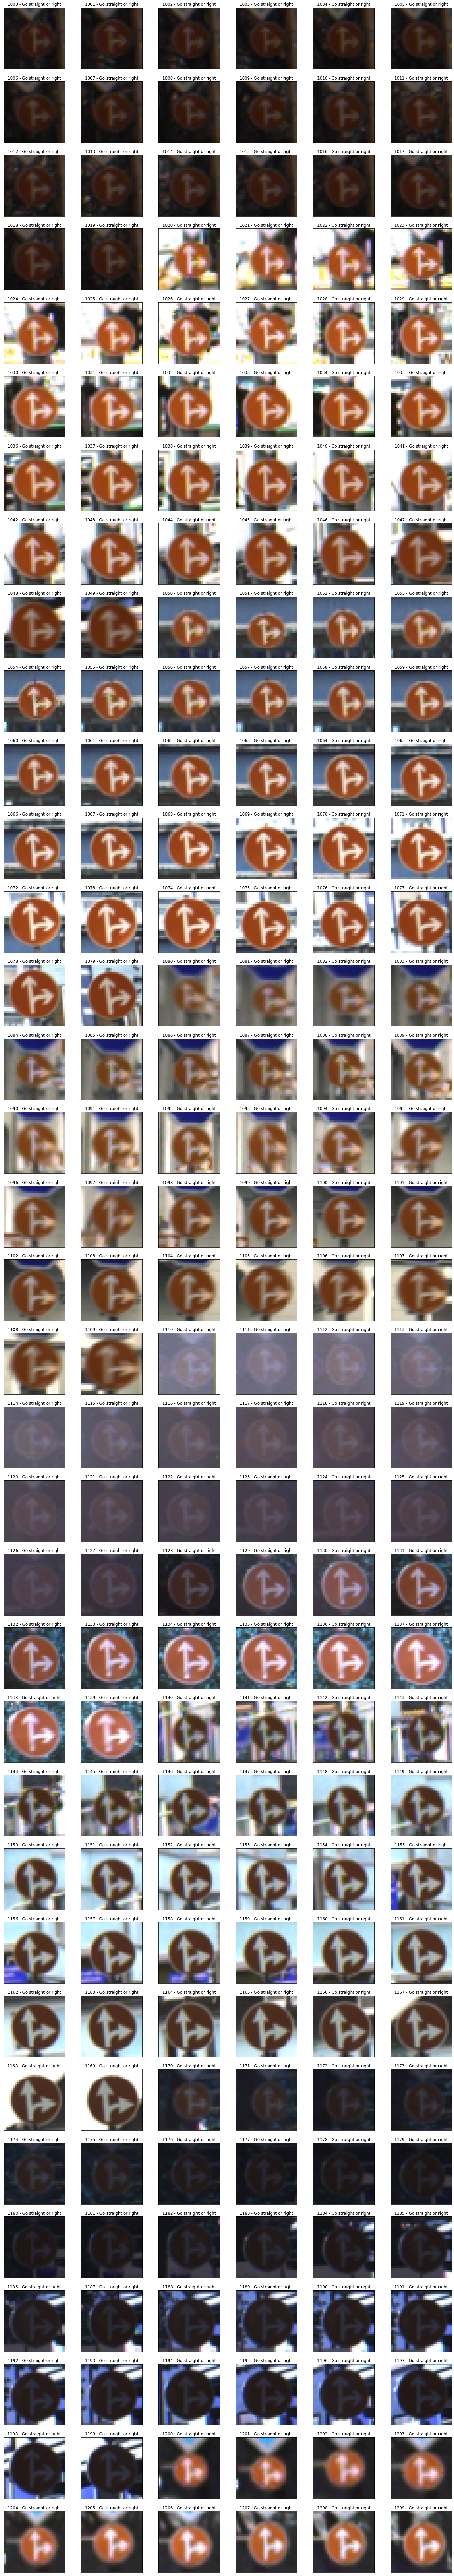

In [ ]:
n_plot = 200
n_rows = 30
cols = n_plot//n_rows
rows = n_plot//cols + n_plot%cols
fig,axs = plt.subplots(rows,cols, figsize=(cols*4,rows*4))
i = 1000
for row in range(rows):
  for col in range(cols):
    
    ax = axs[row,col]
    ax.set_yticks([])
    ax.set_xticks([])
    v = train.get('labels')[i]  
    img = train.get('features')[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.set_title("{} - {}".format(i,signnames[v]))
    ax.imshow(img)
    i+=1

    


Evidentemente hay muchas imagenes similares. Pareciera ser del mismo cartel pero tomadas en instantes distintos, o modificadas artificialmente

Para ver un poco cómo son las imágenes de cada clase, ploteamos una de cada una

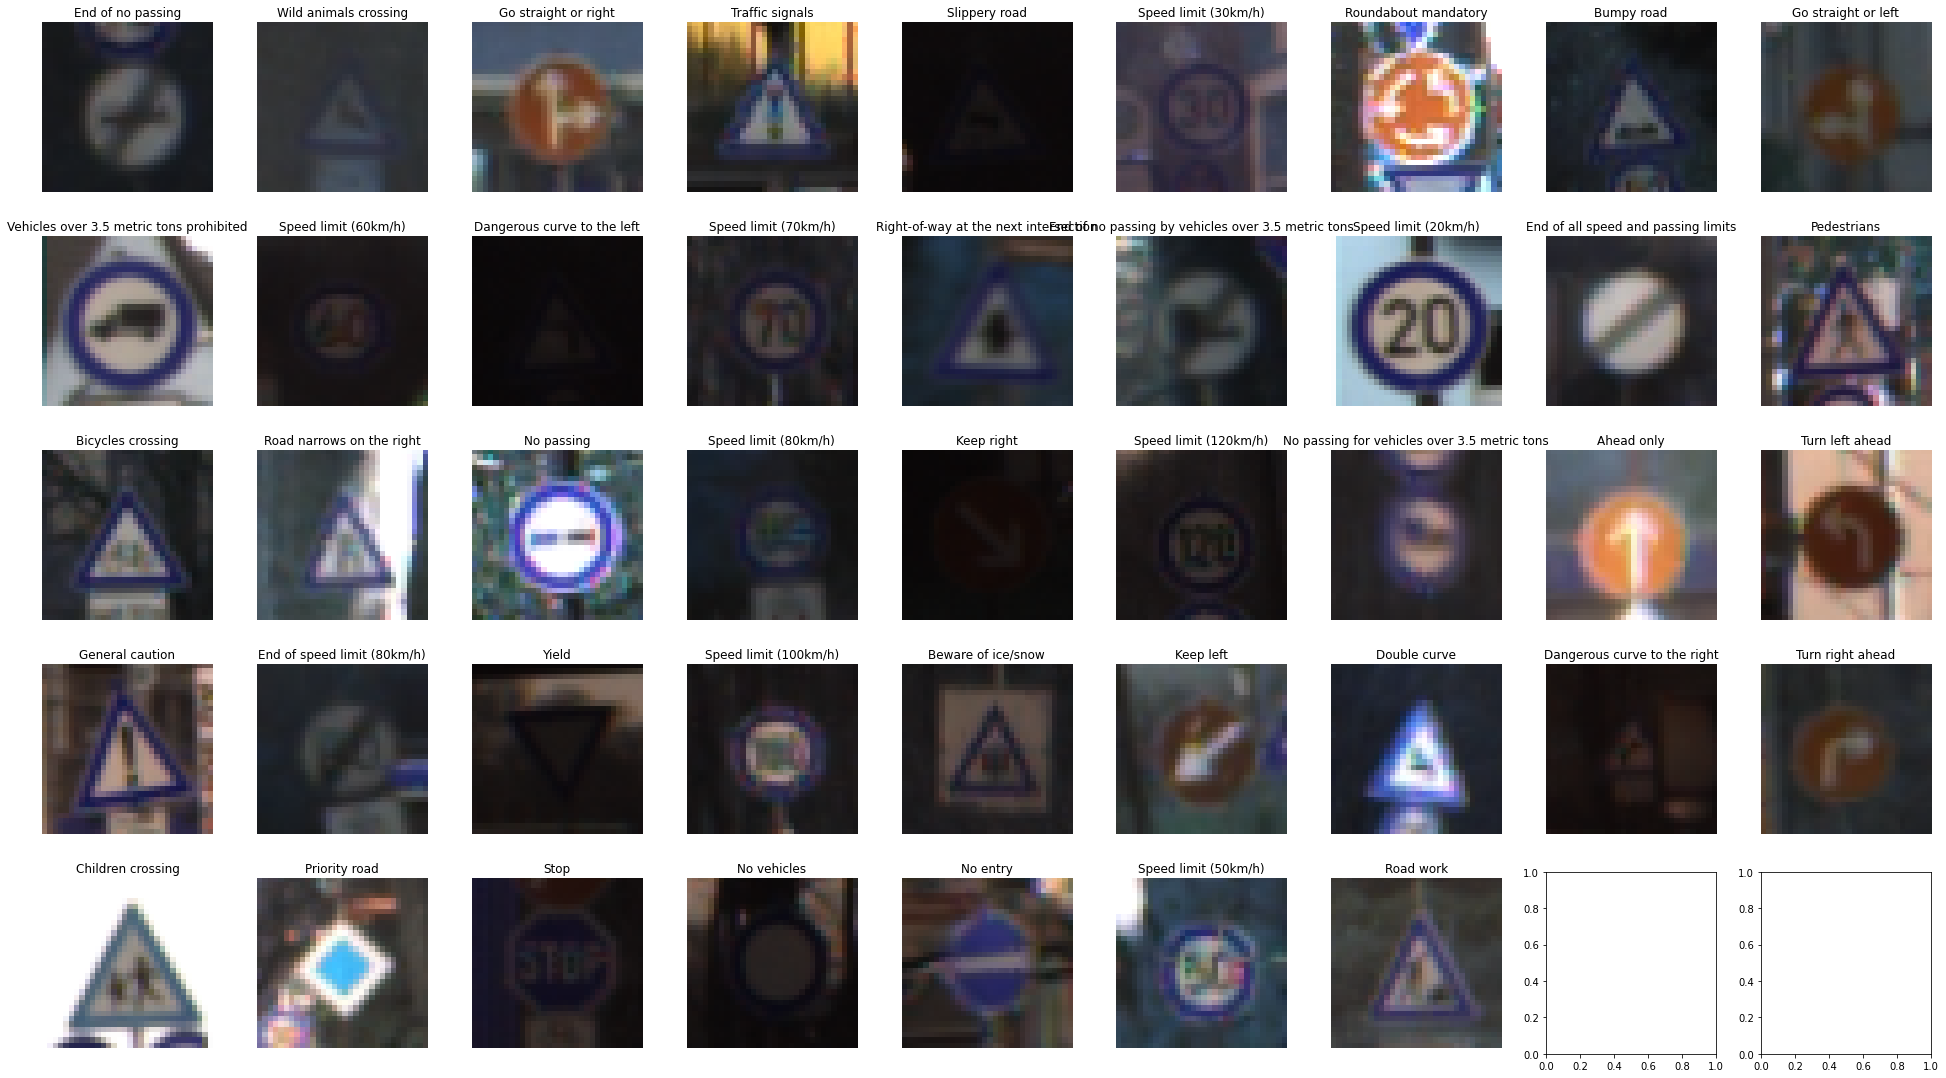

In [ ]:
sign_list= np.unique(train['labels']).tolist()

fig,axs = plt.subplots(5,9,figsize=(9*3,5*3))
fig.tight_layout()
found=0
for i,v in enumerate(train.get('labels')):
  if(v in sign_list):
    
    sign_list.remove(v)
    img = train.get('features')[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax = axs[found//9][found%9]
    found+=1
    ax.set_axis_off()
    ax.set_title(signnames.get(v))
    ax.imshow(img)

#2 Procesamiento de datos

###2.1. Ecualización 

Notamos que muchas imágenes presentan un contraste bajo por lo que aplicaremos ecualización de histograma

In [ ]:
#Imágenes muy oscuras necesidad de ecualizar
def equalize(image_src, with_plot=False, gray_scale=False):
    
    if not gray_scale:
        r_image, g_image, b_image = cv2.split(image_src)

        r_image_eq = cv2.equalizeHist(r_image)
        g_image_eq = cv2.equalizeHist(g_image)
        b_image_eq = cv2.equalizeHist(b_image)

        image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
        cmap_val = None
    else:
        image_eq = cv2.equalizeHist(image_src)
        cmap_val = 'gray'

    if with_plot:
        fig = plt.figure(figsize=(10, 20))

        ax1 = fig.add_subplot(2, 2, 1)
        ax1.axis("off")
        ax1.title.set_text('Original')
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.axis("off")
        ax2.title.set_text("Equalized")

        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_eq, cmap=cmap_val)
        return True
    return image_eq

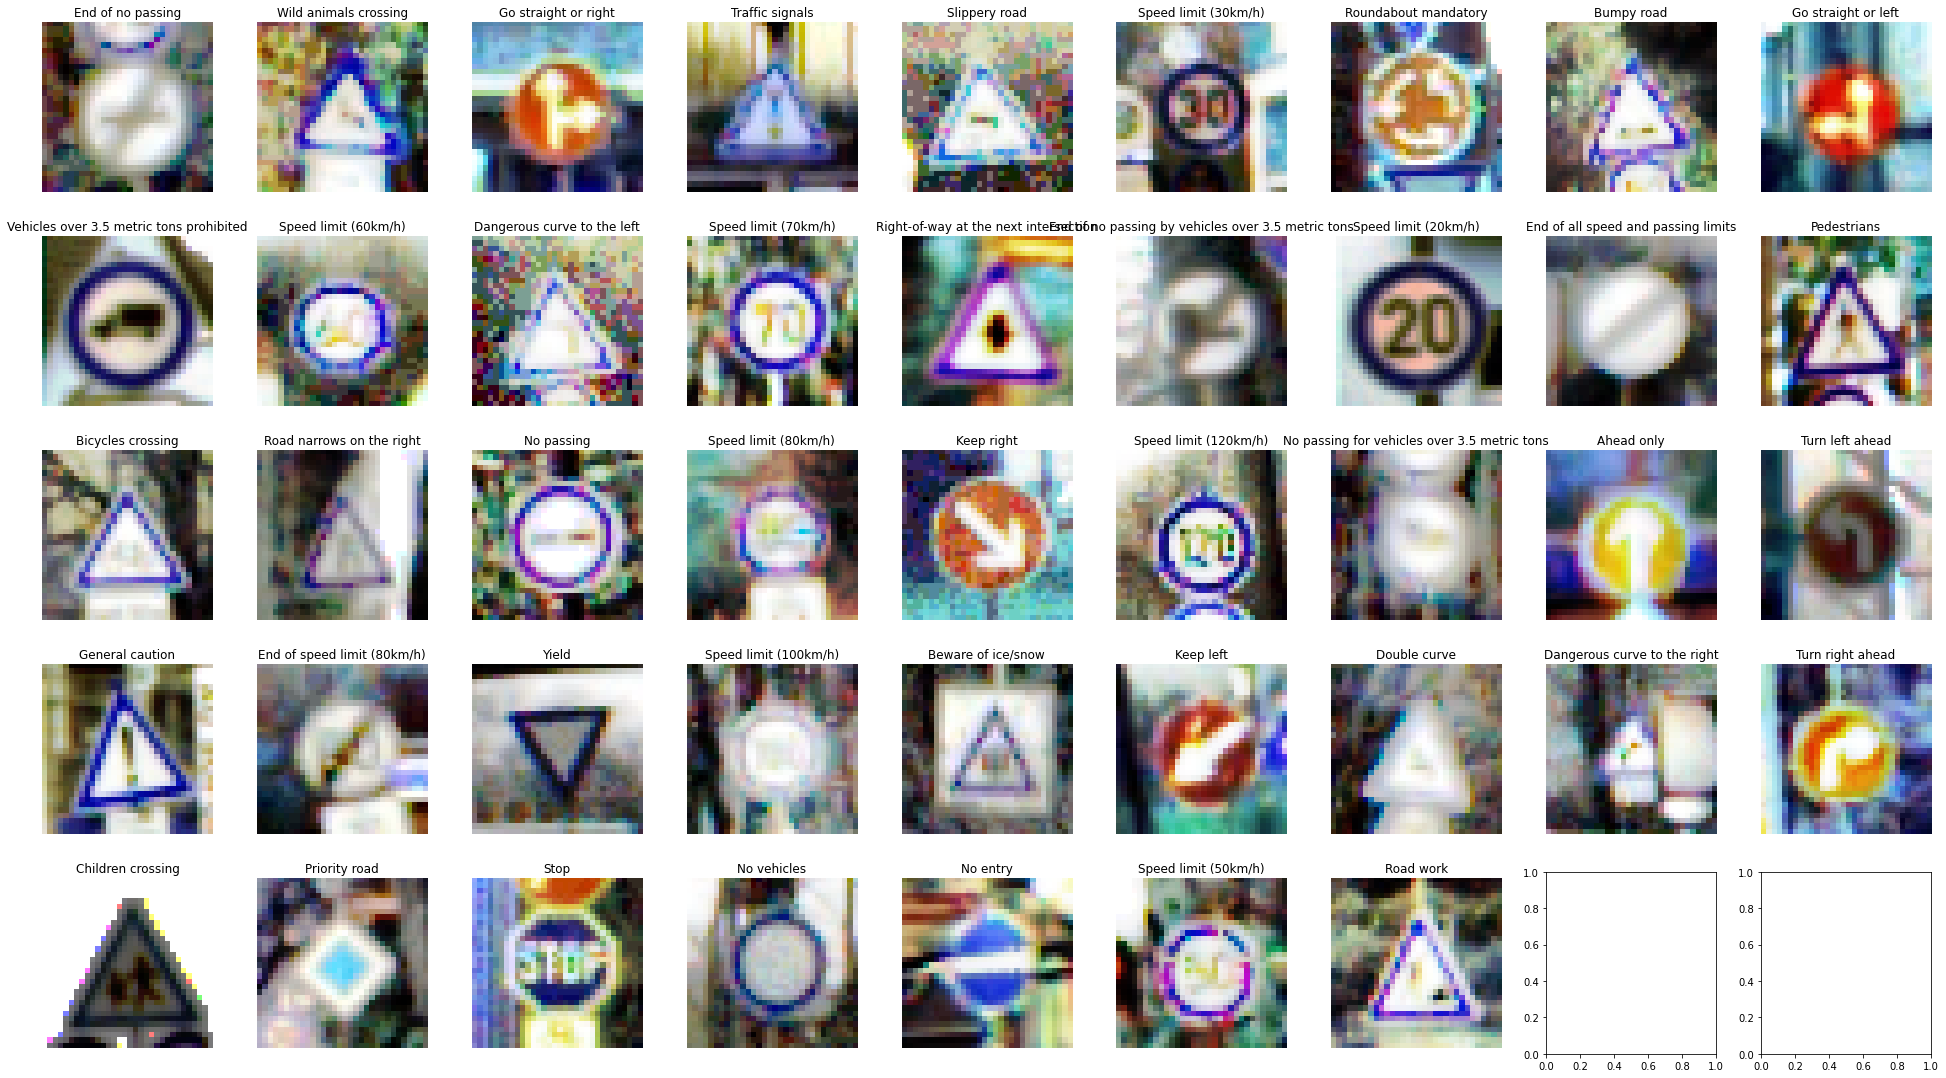

In [ ]:
sign_list= np.unique(train['labels']).tolist()

fig,axs = plt.subplots(5,9,figsize=(9*3,5*3))
fig.tight_layout()
found=0
for i,v in enumerate(train.get('labels')):
  if(v in sign_list):
    
    sign_list.remove(v)
    img = train.get('features')[i]
    img = equalize(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax = axs[found//9][found%9]
    found+=1
    ax.set_axis_off()
    ax.set_title(signnames.get(v))
    ax.imshow(img)

In [ ]:
#Función para ecualizar conjunto
def equalize_sets(features):
  for i in range(len(features)):
    if (features.shape==4):
      gray=False
      features[i] = equalize(features[i], gray_scale=gray)
    if (features.shape==3):
      gray=True
      features[i] = equalize(features[i], gray_scale=gray)
  return features


### 2.2. Submuestreo aleatorio

*Incoporamos una función para aplicar experimentos con submuestreo y de esta forma balancear todas las clases para que posean la misma cantidad de observaciones que la clase menos representada (clase minoritaria) en el conjunto*

In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

#Función para balancear clases mendiante el submuestreo a cantidad de observaciones de clase minoritaria
def undersampling(features, labels):
  undersample = RandomUnderSampler(sampling_strategy='all')
  if(len(features.shape)==4):
    X, y = undersample.fit_resample(features.reshape(len(features),features.shape[1]*features.shape[2]*features.shape[3]), labels)
    X = X.reshape(len(X),features.shape[1],features.shape[2],features.shape[3])
  if(len(features.shape)==3):
    X, y = undersample.fit_resample(features.reshape(len(features),features.shape[1]*features.shape[2]), labels)
    X = X.reshape(len(X),features.shape[1],features.shape[2])
  return X,y


###2.3. Conversión a gris eliminar

*Incorporamos una función para convertir las imágenes a escala de gris y evaluar reducción de dimensionalidad para una imagen de un solo canal de color*

In [ ]:
def color_to_gray(X_color):
  X_gray =[]
  for i in range(len(X_color)):
    gray = cv2.cvtColor(X_color[i], cv2.COLOR_BGR2GRAY)
    X_gray.append(gray)
  return np.array(X_gray)

###2.4 Normalización

In [ ]:
def normalize(X):
  X = X.astype('float32')/255
  return X

### 2.6 Aplicación de preprocesamiento

In [ ]:
#Features originales (todas las observaciones)
X_train, y_train = train.get('features'), train.get('labels')
X_val, y_val = val.get('features'), val.get('labels')
X_test, y_test = test.get('features'), test.get('labels')

#Conversión gris
X_train_g = color_to_gray(X_train)
X_val_g = color_to_gray(X_val)
X_test_g = color_to_gray(X_test)

#Ecualización (color y gris)
X_train = equalize_sets(X_train)
X_val = equalize_sets(X_val)
X_test = equalize_sets(X_test)

X_train_g = equalize_sets(X_train_g)
X_val_g = equalize_sets(X_val_g)
X_test_g = equalize_sets(X_test_g)

#Normalizacion (color y gris)
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

X_train_g = normalize(X_train_g)
X_val_g = normalize(X_val_g)
X_test_g = normalize(X_test_g)

#Vectorización a 1-D (color y gris)
X_train_1d = X_train.reshape(-1,X_train[0].size)
X_val_1d = X_val.reshape(-1,X_val[0].size)
X_test_1d = X_test.reshape(-1,X_test[0].size)

X_train_g_1d = X_train_g.reshape(-1,X_train_g[0].size)
X_val_g_1d = X_val_g.reshape(-1,X_val_g[0].size)
X_test_g_1d = X_test_g.reshape(-1,X_test_g[0].size)

print(X_train_1d.shape,X_train_g_1d.shape)

(34799, 3072) (34799, 1024)


# 3 Análisis de componentes principales


### 3.1 PCA

Evaluamos un PCA de dos componentes principales, para ver qué pasa con la visualización

In [ ]:
pca2c = PCA(n_components=2)
pca2c.fit(X_train_1d)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

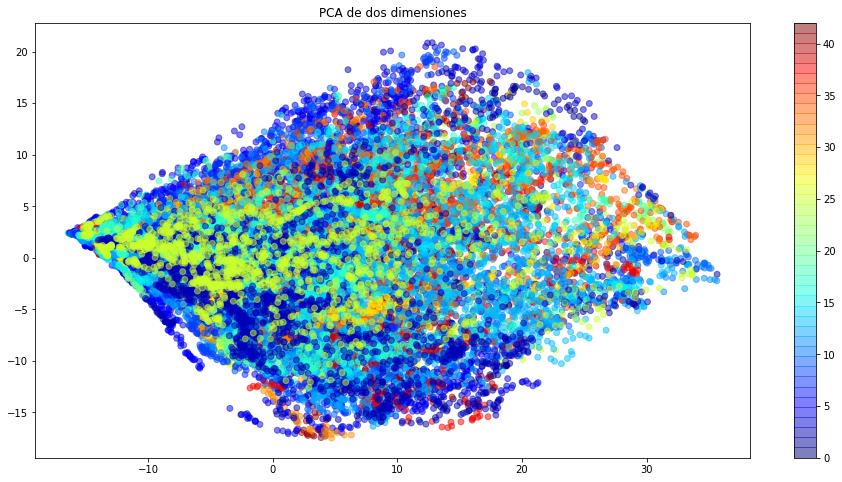

In [ ]:
plt.figure(figsize=(16,8))
cmap_classes = plt.cm.get_cmap('jet', len(set(train['labels'])))
plt.scatter(x=pca2c.transform(X_train_1d)[:,0],
            y=pca2c.transform(X_train_1d)[:,1],
            c=y_train,s=35,cmap=cmap_classes,alpha=0.5)
plt.title("PCA de dos dimensiones")
plt.colorbar()
plt.show()

Ahora probamos visualizar con 3 dimensiones. Para asistir la visualización, vamos a agrupar las clases en categorías de más alto nivel

In [ ]:
pca3c = PCA(n_components=3)
pca3c.fit(X_train_1d)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
signnames

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

In [ ]:
group_keywords = ['speed limit','turn','keep','no ','go ','crossing','curve','others']
grouped_classes = dict.fromkeys(signnames.keys())
for k,v in signnames.items():
  found = False
  for group in group_keywords:
    if group in v.lower():
      grouped_classes[k] = group
      found = True
  if not found:
    grouped_classes[k] = 'others'
    

In [ ]:
grouped_classes

{0: 'speed limit',
 1: 'speed limit',
 2: 'speed limit',
 3: 'speed limit',
 4: 'speed limit',
 5: 'speed limit',
 6: 'speed limit',
 7: 'speed limit',
 8: 'speed limit',
 9: 'no ',
 10: 'no ',
 11: 'others',
 12: 'others',
 13: 'others',
 14: 'others',
 15: 'no ',
 16: 'others',
 17: 'no ',
 18: 'others',
 19: 'curve',
 20: 'curve',
 21: 'curve',
 22: 'others',
 23: 'others',
 24: 'others',
 25: 'others',
 26: 'others',
 27: 'others',
 28: 'crossing',
 29: 'crossing',
 30: 'others',
 31: 'crossing',
 32: 'others',
 33: 'turn',
 34: 'turn',
 35: 'others',
 36: 'go ',
 37: 'go ',
 38: 'keep',
 39: 'keep',
 40: 'others',
 41: 'no ',
 42: 'no '}

In [ ]:
labels_train = [grouped_classes[idx] for idx in y_train]
pd.Series(labels_train).value_counts()

others         12210
speed limit    11760
no              5070
keep            2130
crossing        1410
turn             959
curve            750
go               510
dtype: int64

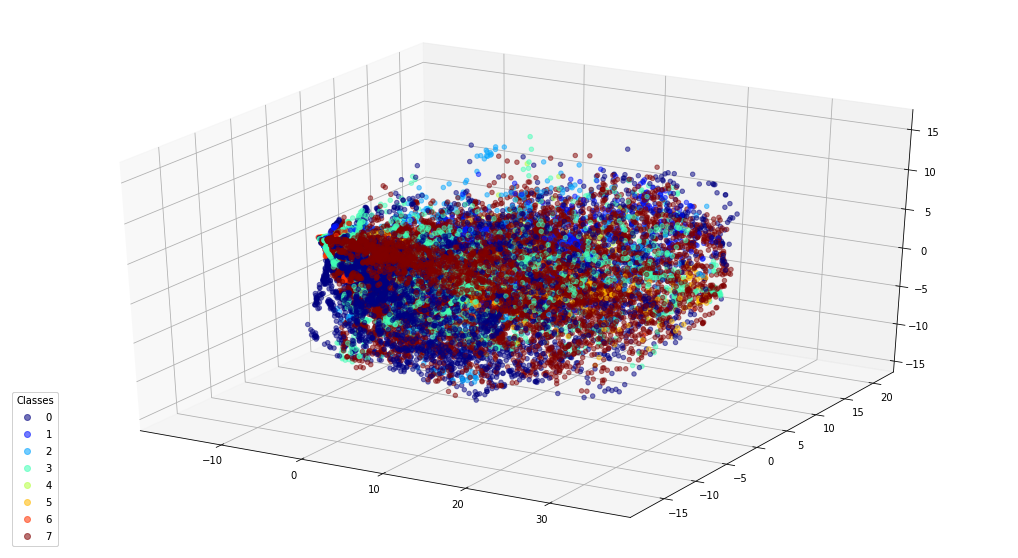

In [ ]:
pca_features = pca3c.transform(X_train_1d)
fig=plt.figure(figsize=(18,10))
cmap_classes = plt.cm.get_cmap('jet', len(group_keywords))

ax = fig.add_subplot(111,projection='3d')

scatter=ax.scatter3D(pca_features[:,0], pca_features[:,1], pca_features[:,2], 
                     c=[group_keywords.index(grouped_classes[idx]) for idx in y_train],                     
                     cmap=cmap_classes,
                     alpha=0.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)


### 3.2 Cantidad de componentes
Evaluamos el método de componentes principales para reducir la dimensión. Probamos con una configuración que estima el número ideal de componentes con un método basado en selección bayesiana según la densidad del espacio, propuesto por Minka en "Automatic choice of dimensionality for PCA". Sin embargo, el tiempo de entrenamiento era demasiado largo y no conseguimos concretarlo. 

Por eso haremos un gráfico de codo para identificar un número de componentes que pueda ser óptimo. Para ello probamos entrenar algoritmos de clusterizacion (k-means) con distinto numero de clusters y evaluamos como se comporta la distorsión y la inercia

In [ ]:
#pca = PCA(n_components='mle') #No se consiguió implementar
#pca.fit(X_train_1d)

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

distortions = []
inertias = []

K = [10,20,100]

for k in K:
    print(k)
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_train_1d)
 
    distortions.append(sum(np.min(cdist(X_train_1d, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_train_1d.shape[0])
    inertias.append(kmeanModel.inertia_)
 


10
20
100


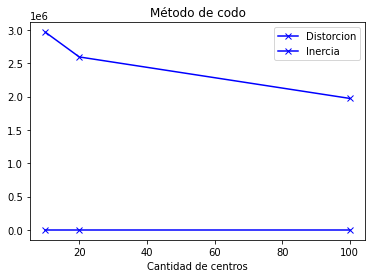

In [ ]:
plt.plot(K, distortions, 'bx-',label='Distorcion')
plt.plot(K, inertias, 'bx-',label='Inercia')

plt.xlabel('Cantidad de centros')
plt.title('Método de codo')
plt.legend()
plt.show()

### 3.3 Búsqueda por grilla con PCA para clasificación

Como PCA realiza una reducción lineal de dimensionalidad, evaluamos su aplicación previo a un clasificador de frontera lineal (regresión logística)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pcaGS = PCA()
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pcaGS), ('logistic', logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 10,15, 20,30],
    'logistic__C': np.logspace(-4, 4, 4),
}
grid_search = GridSearchCV(pipe, param_grid, n_jobs=-1,scoring='accuracy')
grid_search.fit(X_train_1d, y_train)
print("Mejor score (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)


Mejor score (CV score=0.489):
{'logistic__C': 21.54434690031882, 'pca__n_components': 30}


In [ ]:

X_val_1d_pcaGS = grid_search.best_estimator_['pca'].transform(X_val_1d)

print(classification_report(y_val, grid_search.best_estimator_['logistic'].predict(X_val_1d_pcaGS)))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.41      0.61      0.49       240
           2       0.38      0.38      0.38       240
           3       0.15      0.15      0.15       150
           4       0.37      0.40      0.39       210
           5       0.16      0.20      0.18       210
           6       0.60      0.85      0.70        60
           7       0.28      0.23      0.25       150
           8       0.42      0.21      0.28       150
           9       0.42      0.29      0.34       150
          10       0.29      0.75      0.42       210
          11       0.47      0.54      0.50       150
          12       0.80      0.93      0.86       210
          13       0.83      0.90      0.86       240
          14       0.87      0.92      0.90        90
          15       0.58      0.39      0.47        90
          16       0.08      0.03      0.05        60
          17       0.98    

Se obtiene un accuracy de 0.47. No está mal para tratarse de un problema de clasificación de 43 clases (el accuracy del aleatorio es aproximadamente 0.02 en lugar de 0.5 como en clasificación binaria)

In [ ]:
logistic_raw = LogisticRegression(max_iter=10000, tol=0.1)
logistic_raw.fit(X_train_1d, y_train)
print(classification_report(y_val, logistic_raw.predict(X_val_1d)))

              precision    recall  f1-score   support

           0       0.60      0.10      0.17        30
           1       0.70      0.90      0.79       240
           2       0.84      0.84      0.84       240
           3       0.89      0.78      0.83       150
           4       0.64      0.80      0.71       210
           5       0.76      0.77      0.76       210
           6       0.83      0.90      0.86        60
           7       0.82      0.77      0.80       150
           8       0.56      0.80      0.66       150
           9       0.91      0.78      0.84       150
          10       0.80      0.99      0.89       210
          11       0.94      0.86      0.90       150
          12       0.94      0.99      0.96       210
          13       0.91      0.97      0.94       240
          14       1.00      0.96      0.98        90
          15       0.87      0.80      0.83        90
          16       1.00      0.82      0.90        60
          17       0.98    

La regresion logistica a partir de los features originales tardó mucho más en converger pero alcanzó un mejor nivel de accuracy con 0.81

### 3.4 Búsqueda por grilla con Kernel PCA

Intentamos ajustar un KernelPCA para las imágenes a color pero el tamaño del dataset es demasiado grande para el algoritmo, y colapsa la memoria RAM de la notebook. 

Por eso, el kernel PCA lo probamos con imagenes en blanco y negro, donde el feature space original es de 1024 dimensiones. El GridSearch tardaba muchas horas por fit, así que decidimos no recorrer valores para el N de componentes, sino probar los distintos modelos de kernel, dado que la cantidad de componentes puede esperarse que sea la misma que para PCA. Lamentablemente esto tampoco alcanzó, y no pudimos concretar el GridSearch

In [ ]:
X_train_g_1d.shape

(34799, 1024)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
kpcaGS = KernelPCA(random_state=42,n_components=30)

svm = SVC()

param_grid = {    
    'pca__kernel':["poly", "rbf", "sigmoid"],
}

pipe = Pipeline(steps=[('pca', kpcaGS), ('clf', svm)])
grid_search = GridSearchCV(pipe, param_grid, scoring='accuracy')
grid_search.fit(X_train_g_1d, y_train)
print("Mejor score (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

with open(drive_dir+'kpcaGS','wb') as f:
  pickle.dump(grid_search.best_estimator_,f)

In [ ]:
X_val_1d_pcaGS = grid_search.best_estimator_['pca'].transform(X_val_g_1d)

print(classification_report(y_val, grid_search.best_estimator_['clf'].predict(X_val_1d_pcaGS)))


#4 Clasificación 

Evaluamos si los metodos de reduccion de dimensión mejoran el desempeño en clasificación con clasificadores no lineales

In [ ]:
pca = PCA(n_components=30) 
pca.fit(X_train_1d)
X_train_1d_pca = pca.transform(X_train_1d)
with open(drive_dir+'pca20','wb') as f:
  pickle.dump(pca,f)

In [ ]:
kpca = KernelPCA(n_components=30,n_jobs=-1)
kpca.fit(X_train_g_1d)
X_train_1d_kpca = kpca.transform(X_train_g_1d)
with open(drive_dir+'kpca','wb') as f:
  pickle.dump(kpca,f)

### 4.1 MLP



In [ ]:
with open(drive_dir+'pca20','rb') as f:
  pca=pickle.load(f)
with open(drive_dir+'kpca','rb') as f:
  kpca=pickle.load(f)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
#Función para obtener el reporte de clasificación y matriz de confusión
def get_metrics(ytrue, ypred):
  print(classification_report(ytrue, ypred))
  cf_matrix = confusion_matrix(ytrue, ypred)
  fig, ax = plt.subplots(figsize=(50,50))
  sns.heatmap(cf_matrix, annot=True, ax=ax)

ORIGINAL FEATURE SPACE
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        30
           1       0.80      0.90      0.84       240
           2       0.90      0.77      0.83       240
           3       0.87      0.89      0.88       150
           4       0.85      0.97      0.91       210
           5       0.95      0.80      0.87       210
           6       0.94      0.97      0.95        60
           7       0.84      0.94      0.89       150
           8       0.89      0.89      0.89       150
           9       0.81      0.94      0.87       150
          10       0.98      0.95      0.97       210
          11       0.84      0.87      0.86       150
          12       1.00      1.00      1.00       210
          13       0.94      0.99      0.96       240
          14       1.00      0.90      0.95        90
          15       0.95      0.88      0.91        90
          16       1.00      1.00      1.00        60
    

ValueError: ignored

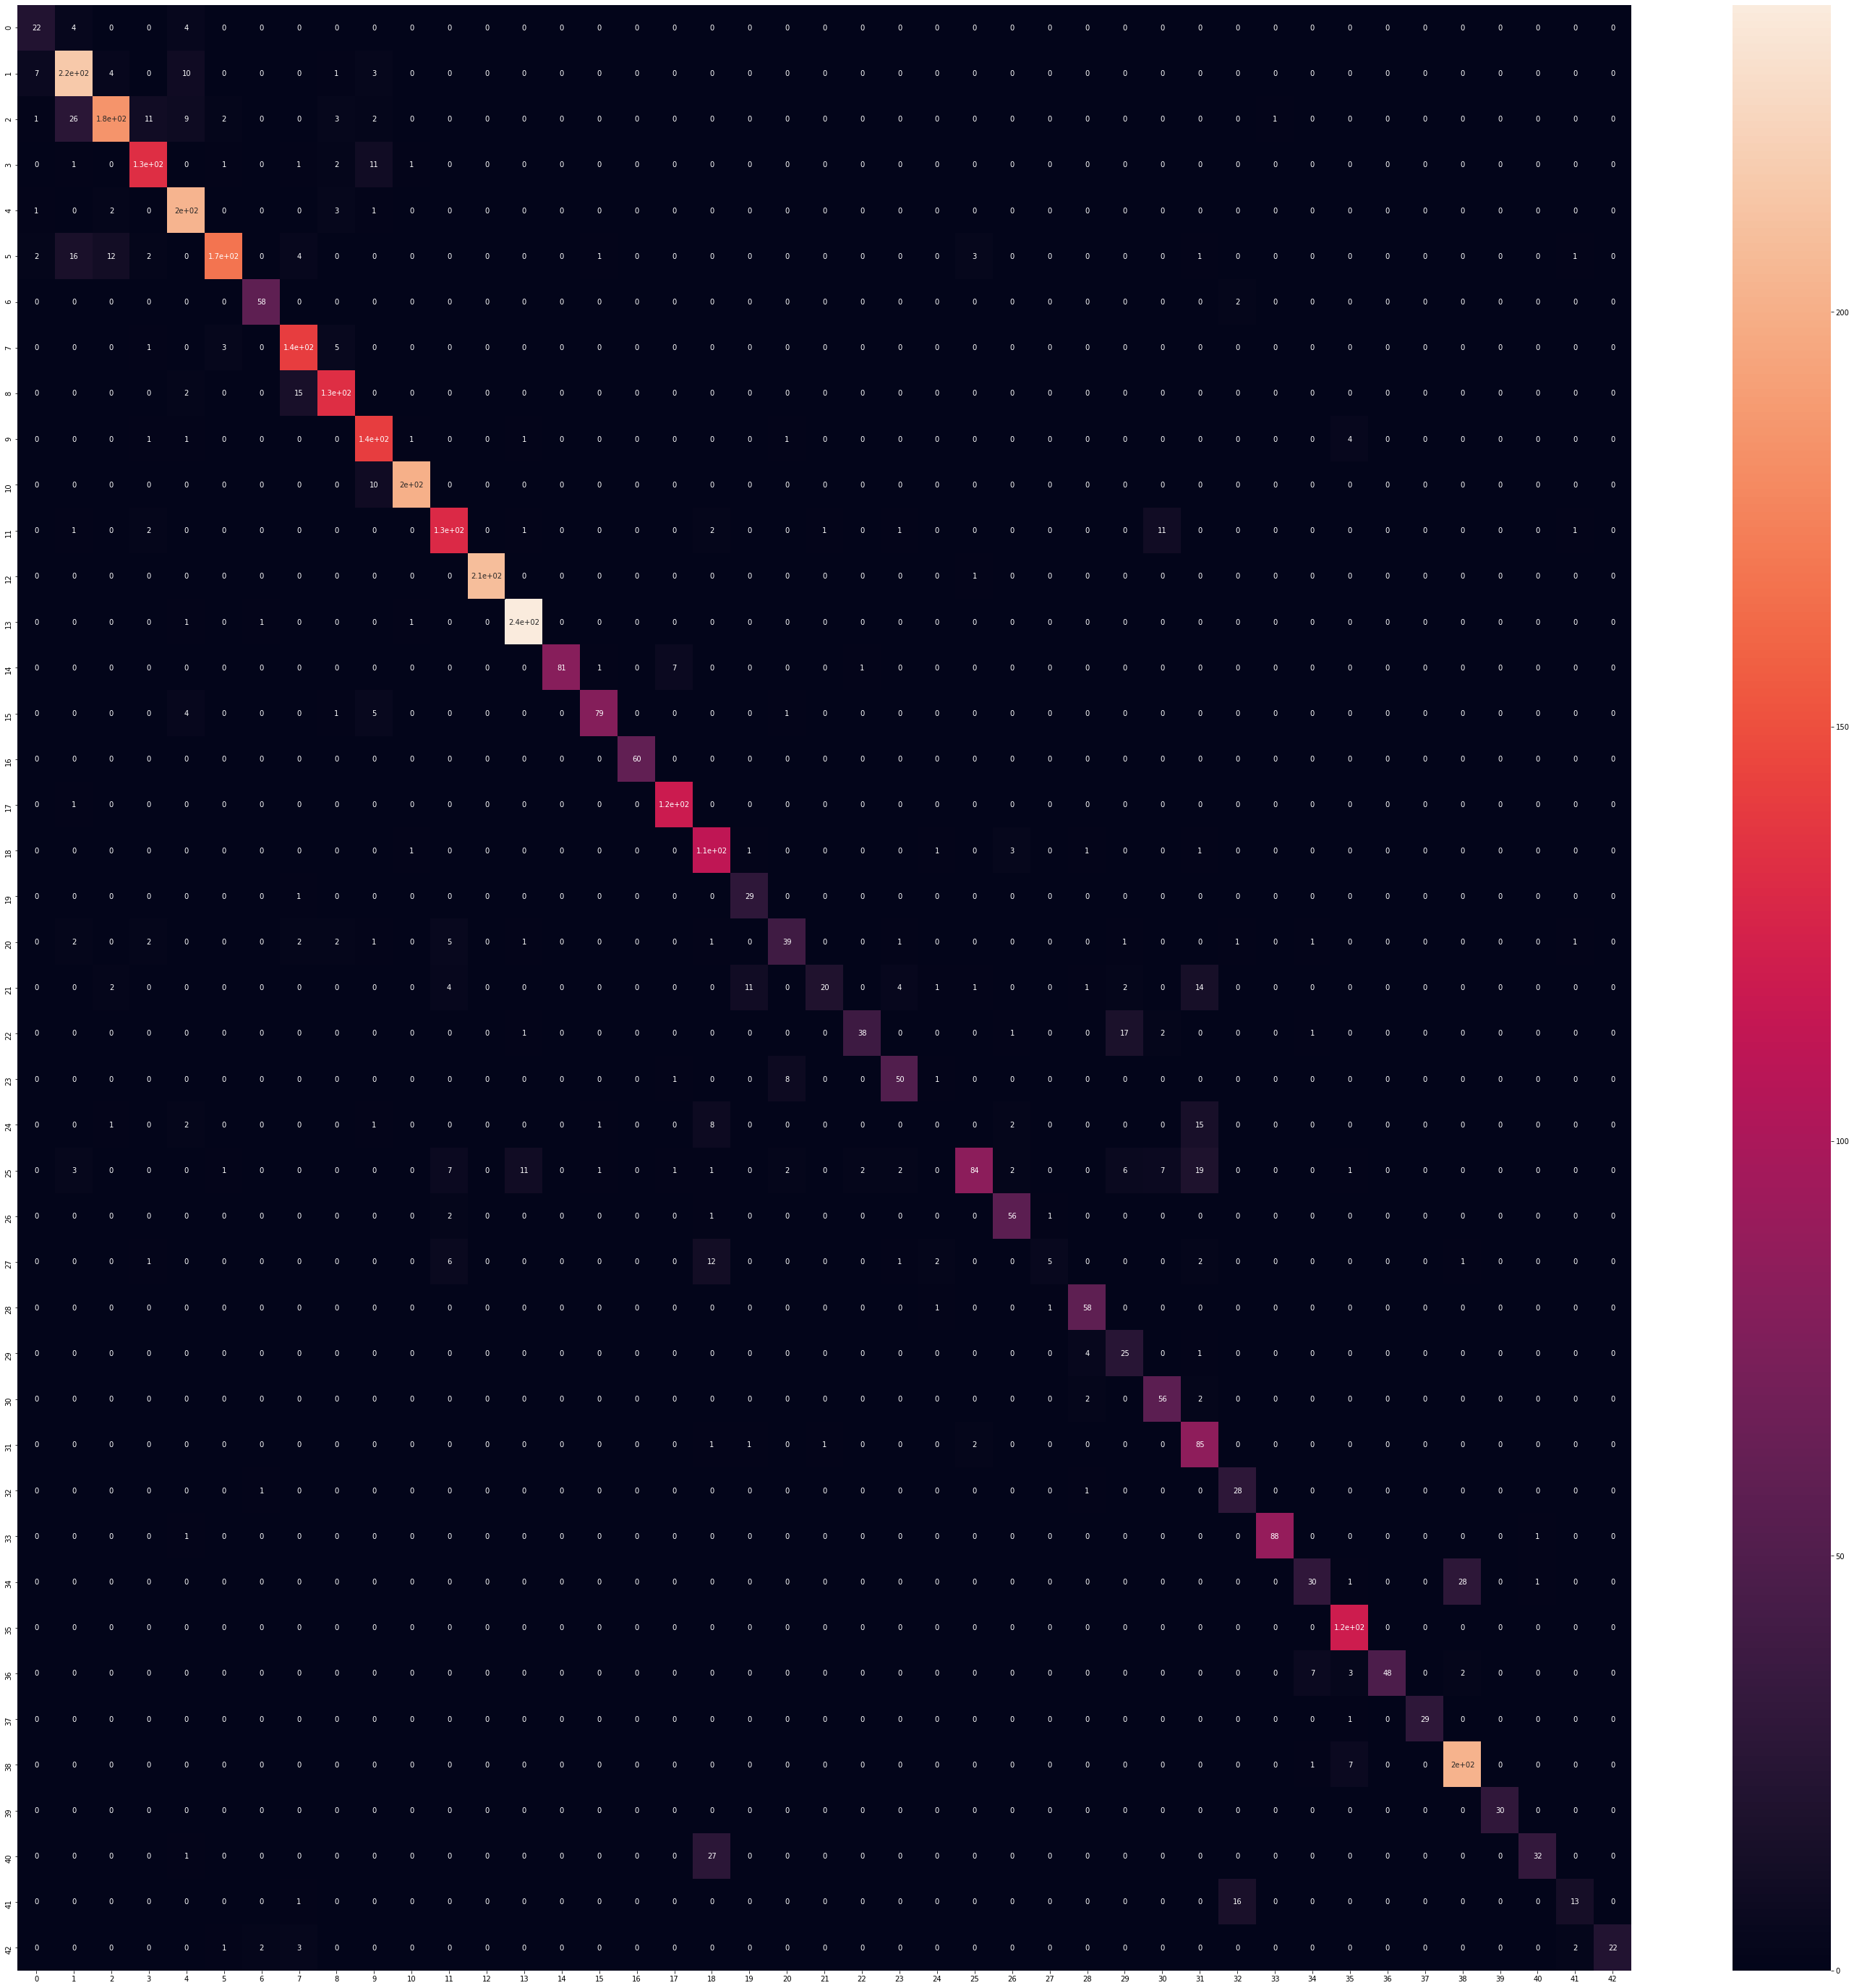

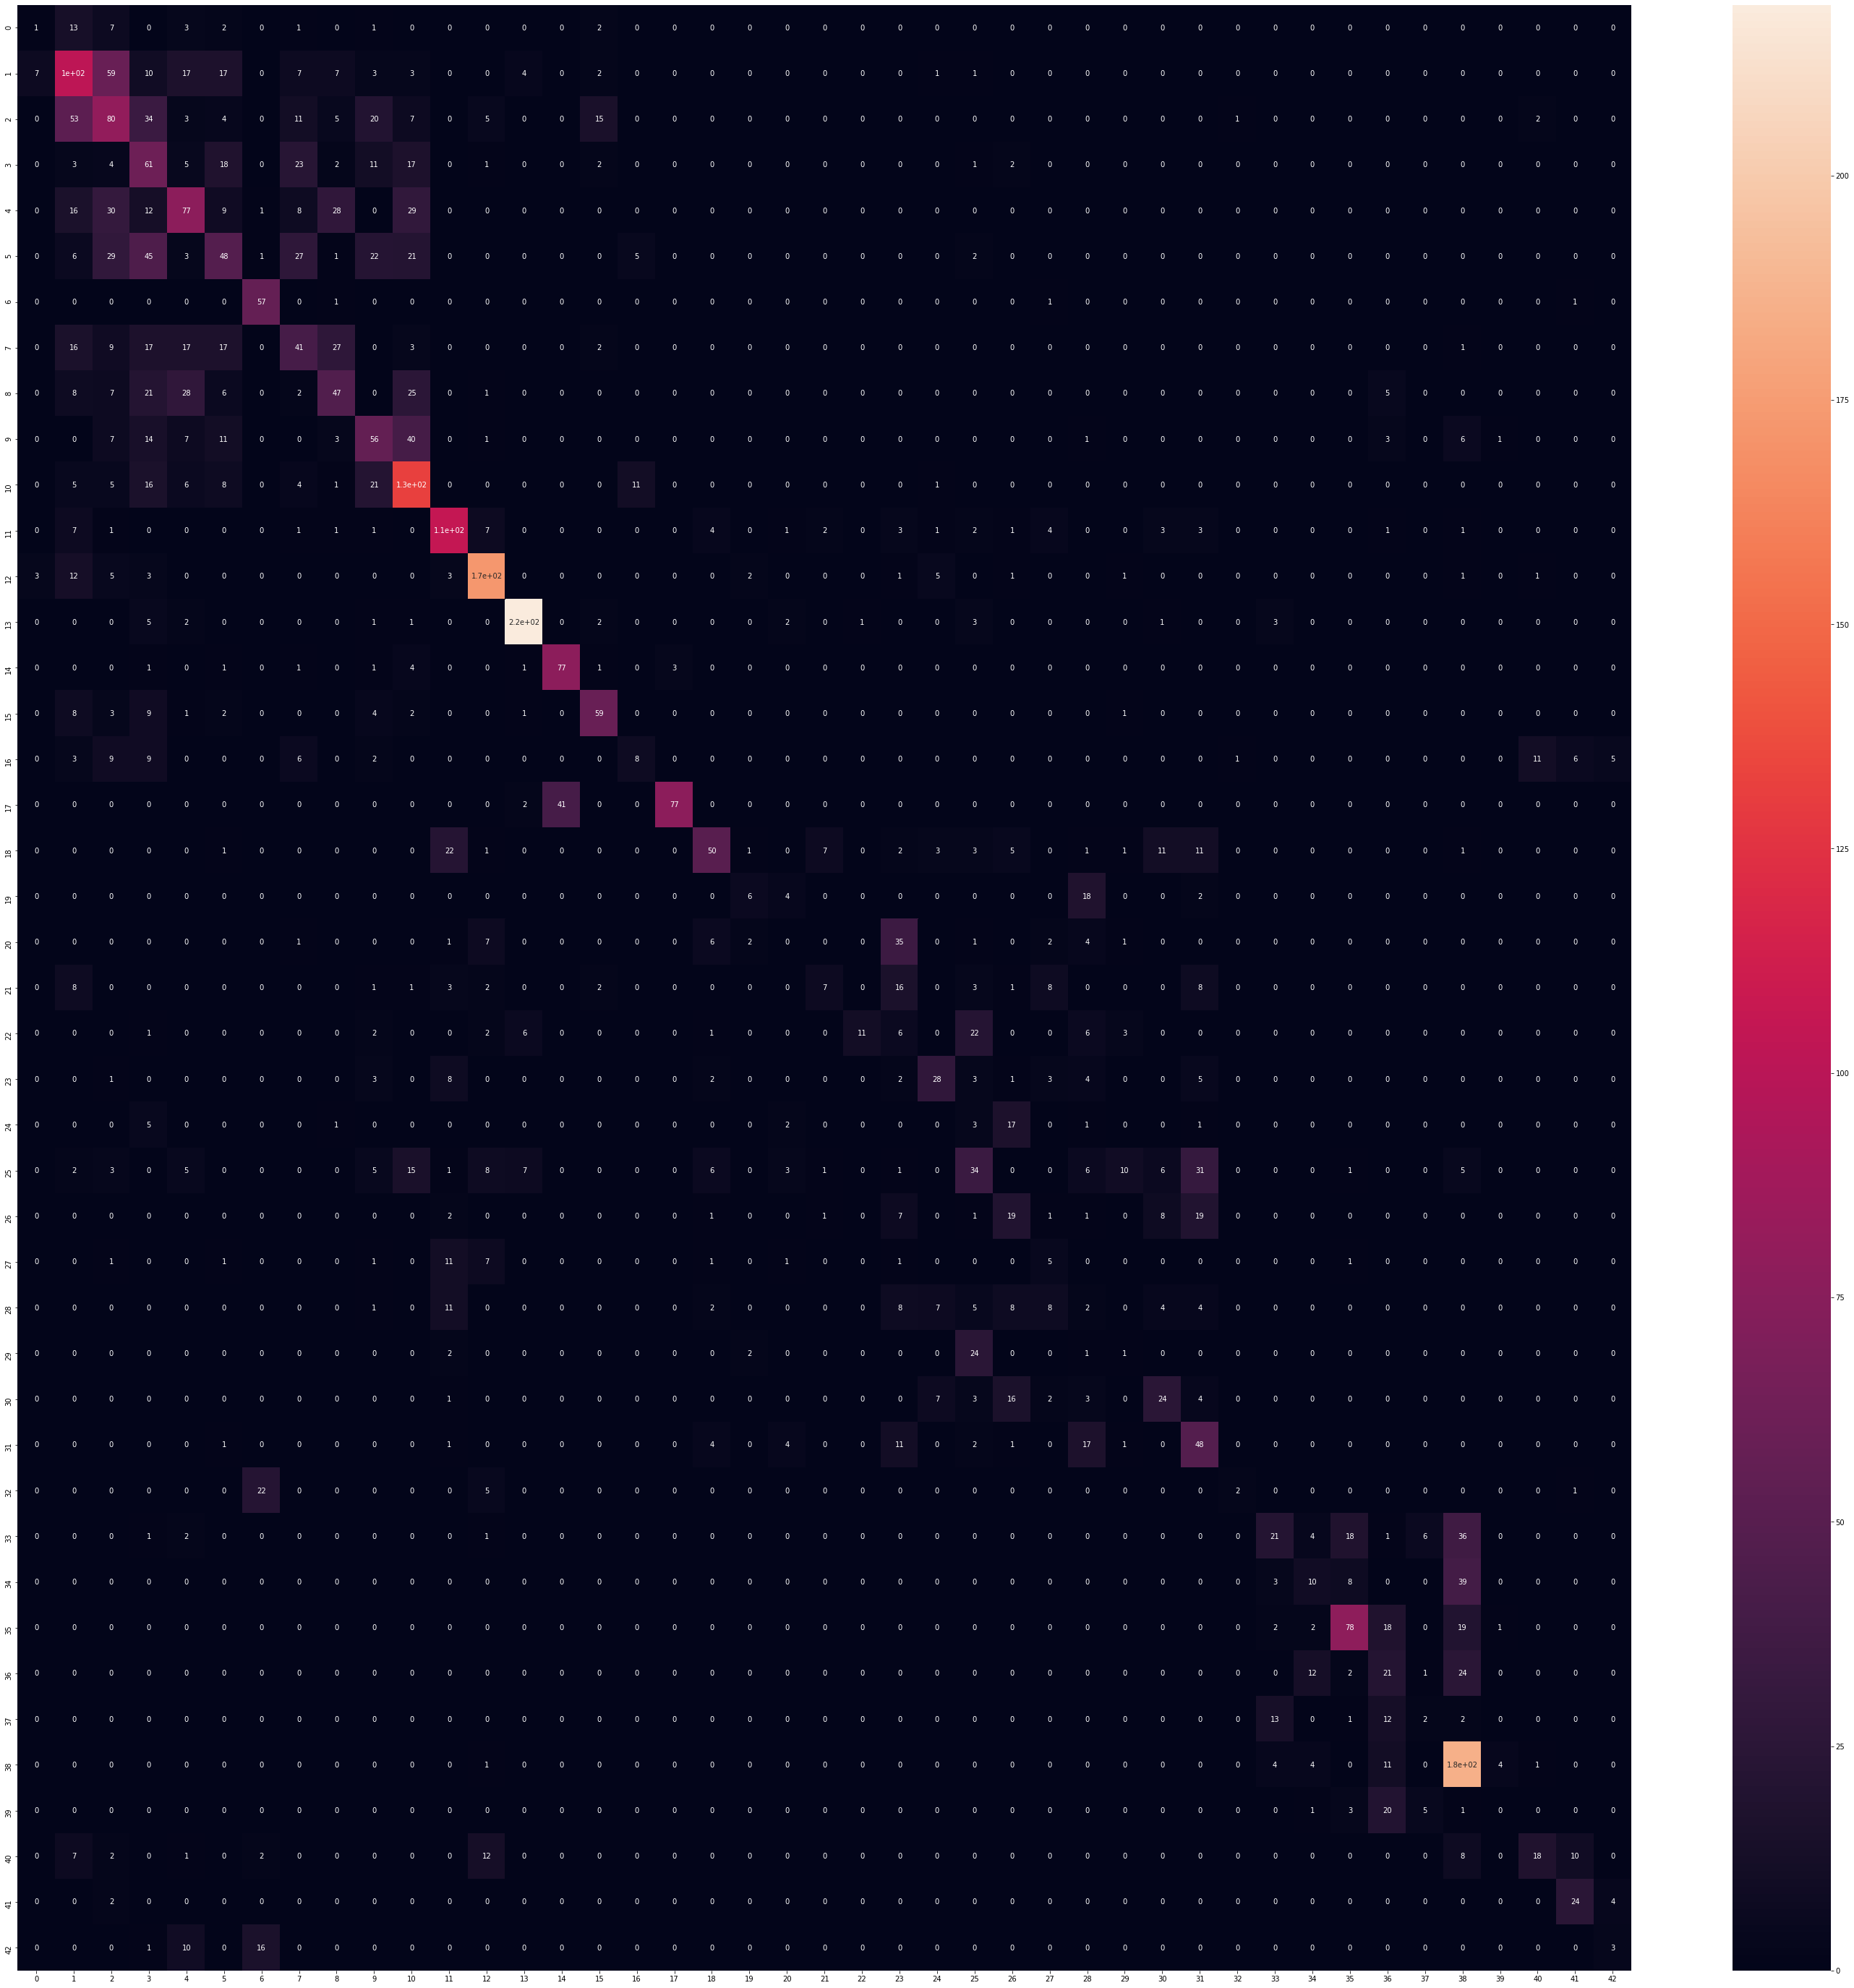

In [ ]:
print('ORIGINAL FEATURE SPACE')

mlp_orig = MLPClassifier().fit(X_train_1d, y_train)
get_metrics(y_val,mlp_orig.predict(X_val_1d)
                         )

print('\n\nPCA FEATURE SPACE')
X_train_1d_pca = pca.transform(X_train_1d)
mlp_pca = MLPClassifier().fit(X_train_1d_pca, y_train)
X_val_1d_pca = pca.transform(X_val_1d)
get_metrics(y_val,mlp_pca.predict(X_val_1d_pca))







KPCA FEATURE SPACE
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.13      0.30      0.18       240
           2       0.13      0.16      0.15       240
           3       0.14      0.18      0.16       150
           4       0.00      0.00      0.00       210
           5       0.02      0.01      0.01       210
           6       0.00      0.00      0.00        60
           7       0.12      0.13      0.12       150
           8       0.15      0.33      0.21       150
           9       0.00      0.00      0.00       150
          10       0.09      0.19      0.12       210
          11       0.02      0.01      0.01       150
          12       0.12      0.08      0.09       210
          13       0.08      0.11      0.09       240
          14       0.10      0.09      0.09        90
          15       0.00      0.00      0.00        90
          16       0.05      0.02      0.02        60
      

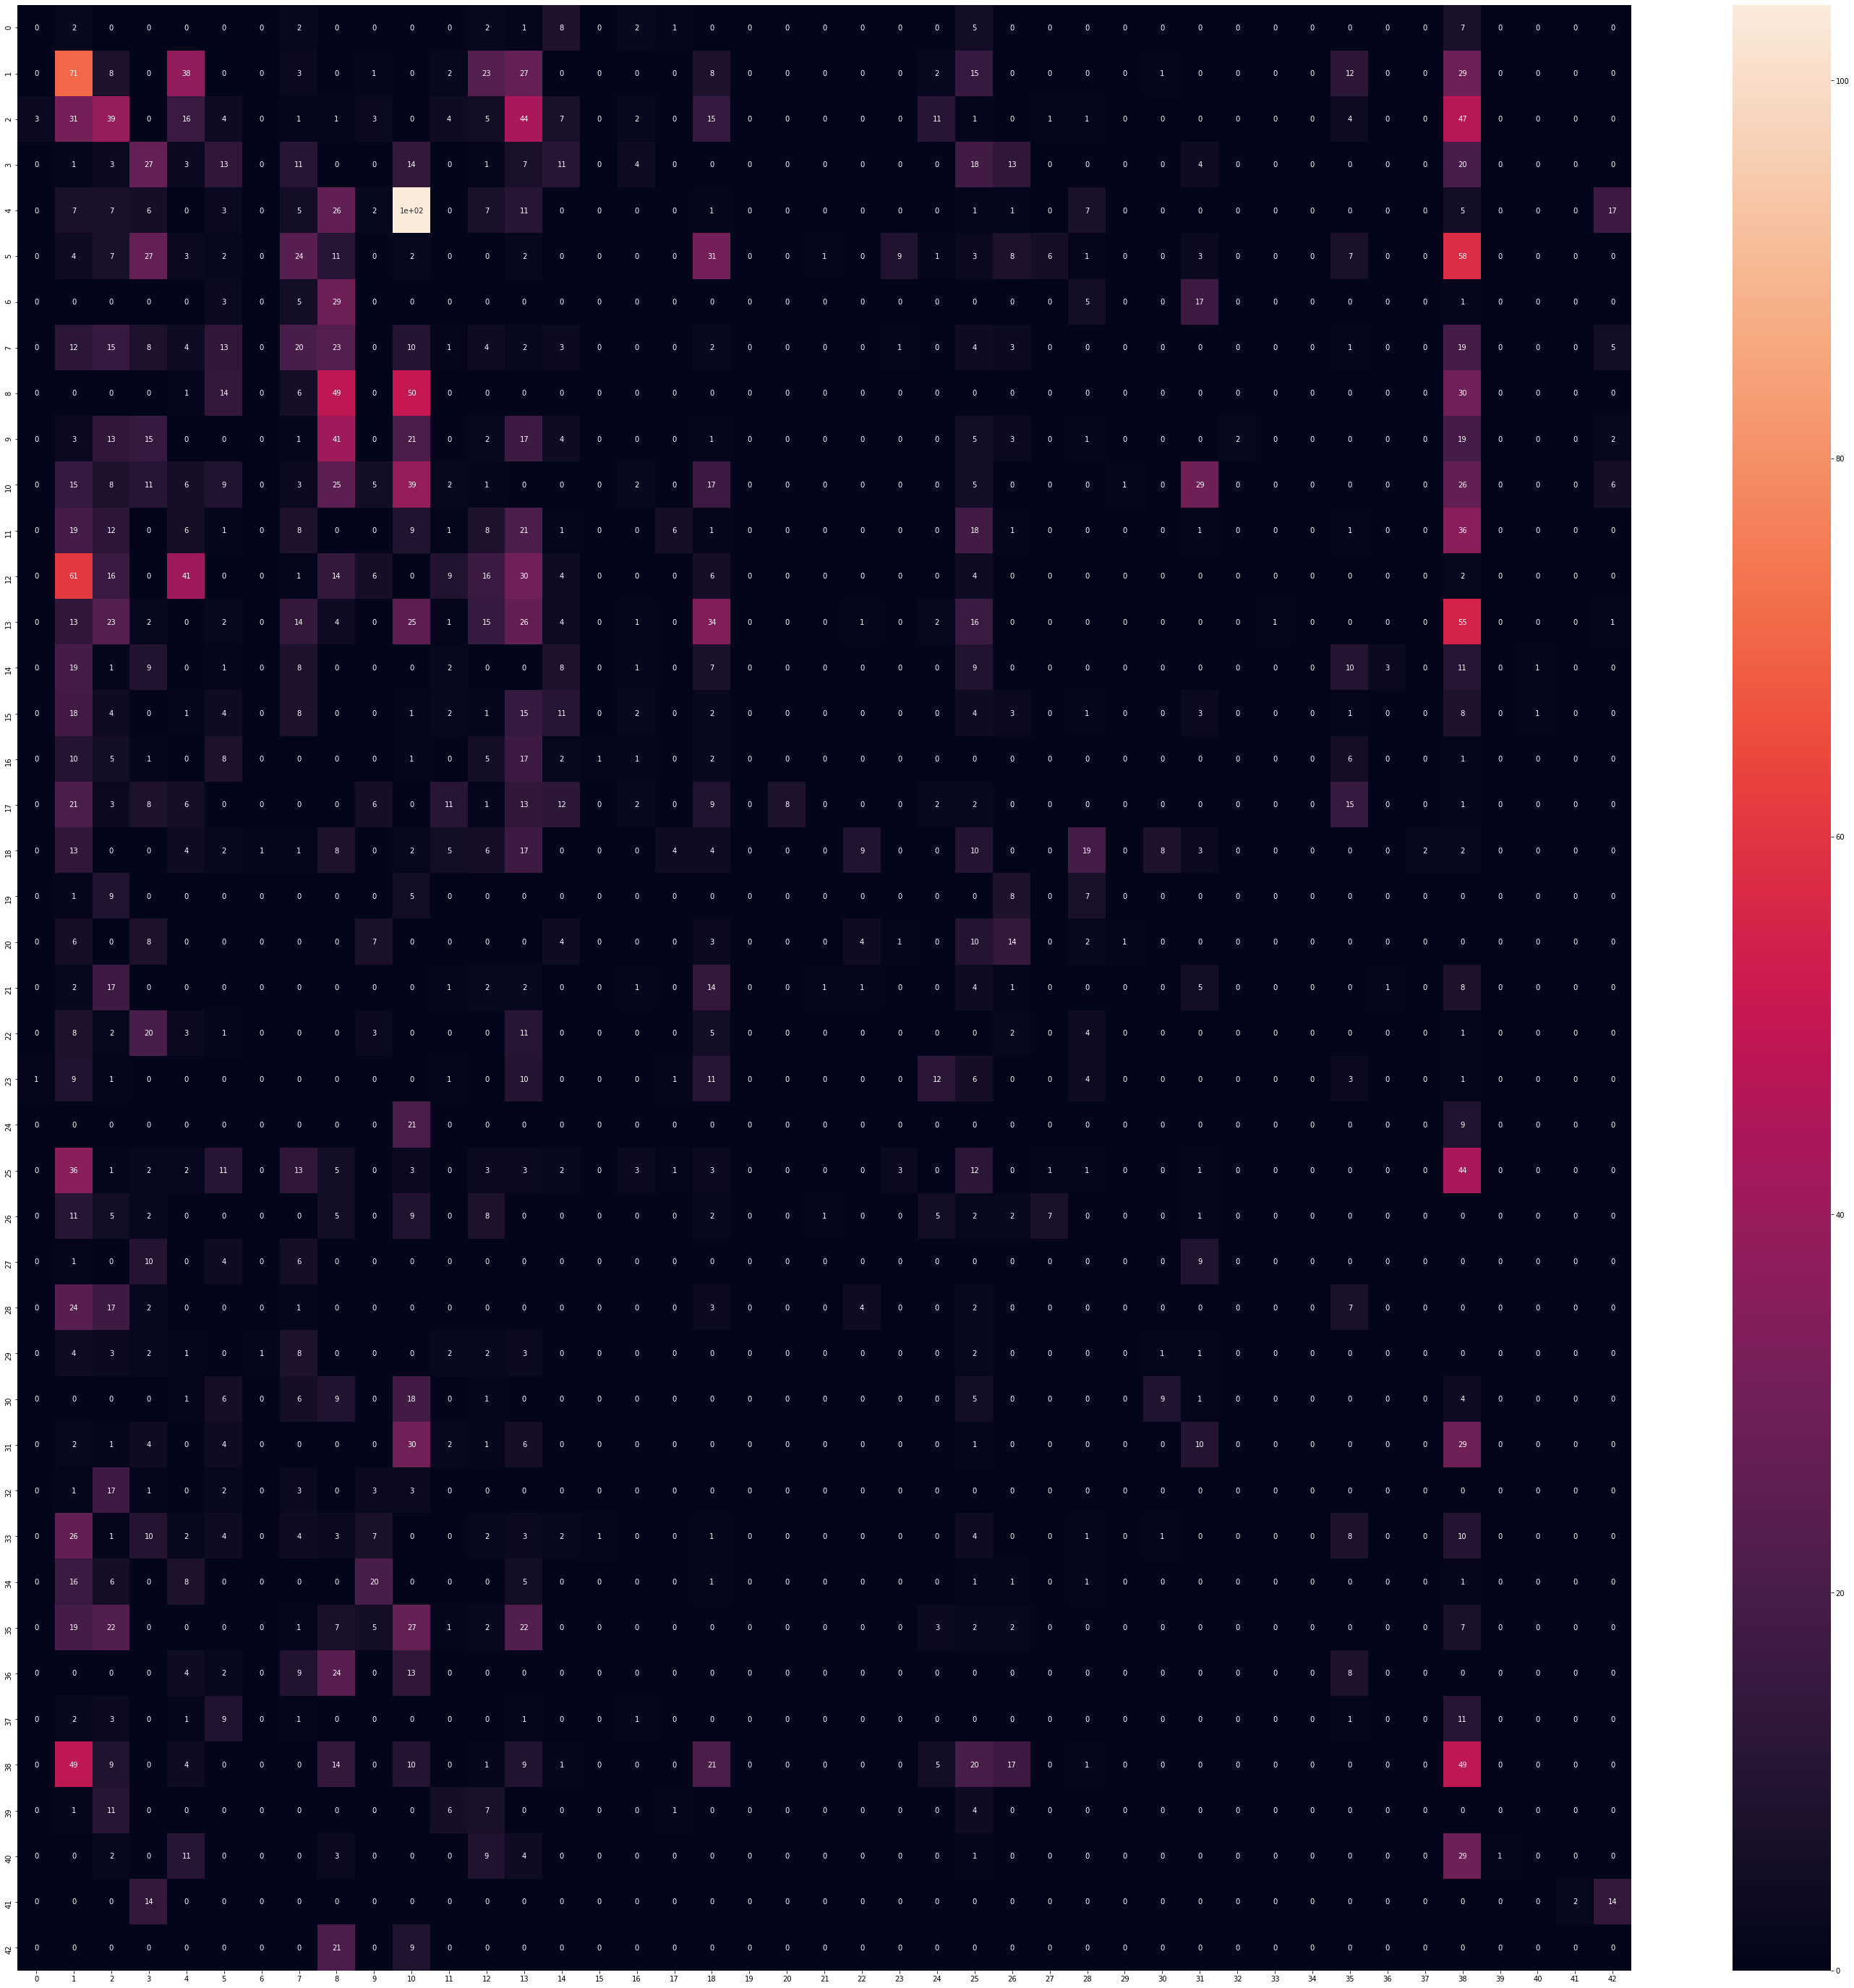

In [ ]:
print('\n\nKPCA FEATURE SPACE')
X_train_g_1d_kpca = kpca.transform(X_train_g_1d)
mlp_kpca = MLPClassifier().fit(X_train_g_1d_kpca, y_train)
X_val_1d_kpca = kpca.transform(X_val_g_1d)
get_metrics(y_val,mlp_kpca.predict(X_val_1d_kpca))

Los métodos de PCA y Kernel PCA parecen empeorar significativamente la clasificación con perceptron multicapa. Sin reducción de dimensionalidad alcanzamos un accuracy de 0.86 promedio entre clases, que aplicando estas técnicas se reduce a 0.45 y 0.09

In [ ]:
mlp_orig

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

Evidentemente esto se debe a que el perceptron  convierte el feature space a un espacio de dimension 100 (tamaño de la capa oculta), y al tener el PCA y KernelPCA menos dimensiones en su feature space, no sirve aplicar luego el perceptron


### 4.2 Random Forest

Probamos el efecto cuando el clasificador es un Random Forest

ORIGINAL FEATURE SPACE
              precision    recall  f1-score   support

           0       0.12      0.07      0.09        30
           1       0.46      0.79      0.58       240
           2       0.44      0.63      0.52       240
           3       0.45      0.71      0.55       150
           4       0.60      0.75      0.66       210
           5       0.36      0.39      0.37       210
           6       0.68      0.83      0.75        60
           7       0.54      0.63      0.58       150
           8       0.59      0.48      0.53       150
           9       0.65      0.53      0.58       150
          10       0.88      0.85      0.86       210
          11       0.72      0.84      0.78       150
          12       0.94      0.92      0.93       210
          13       0.88      0.90      0.89       240
          14       0.79      0.84      0.82        90
          15       0.87      0.43      0.58        90
          16       0.92      0.40      0.56        60
    

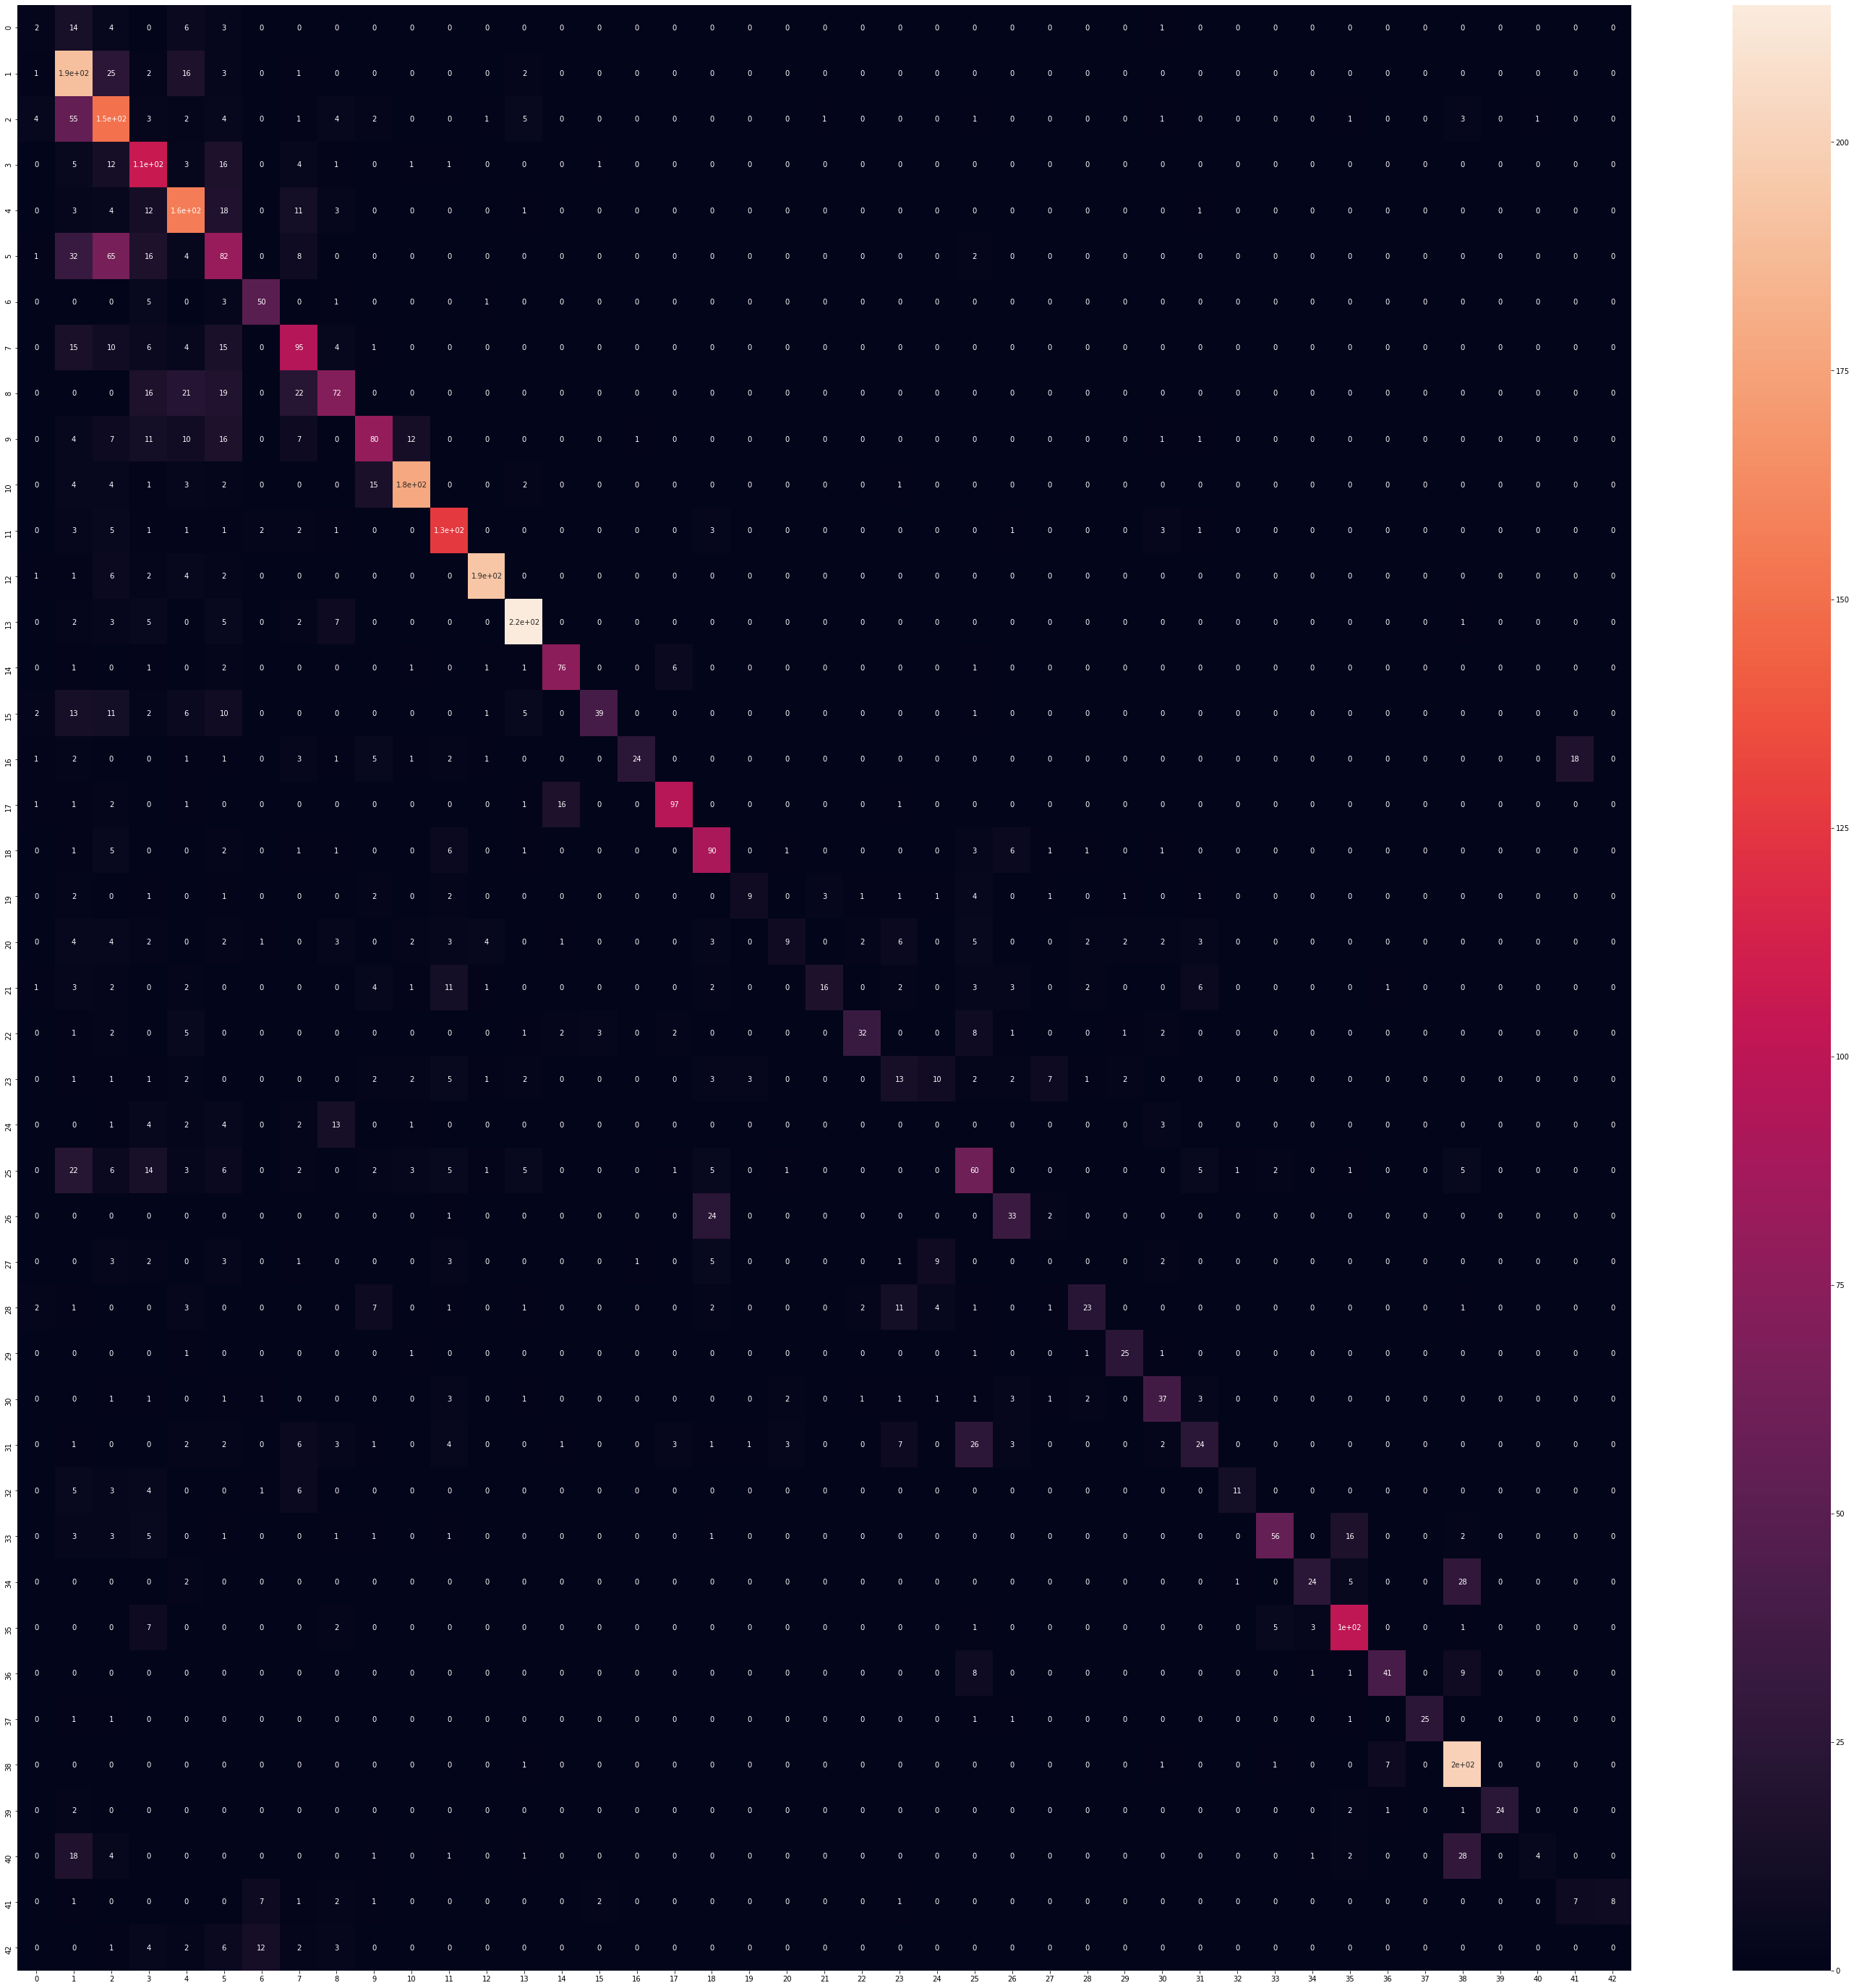

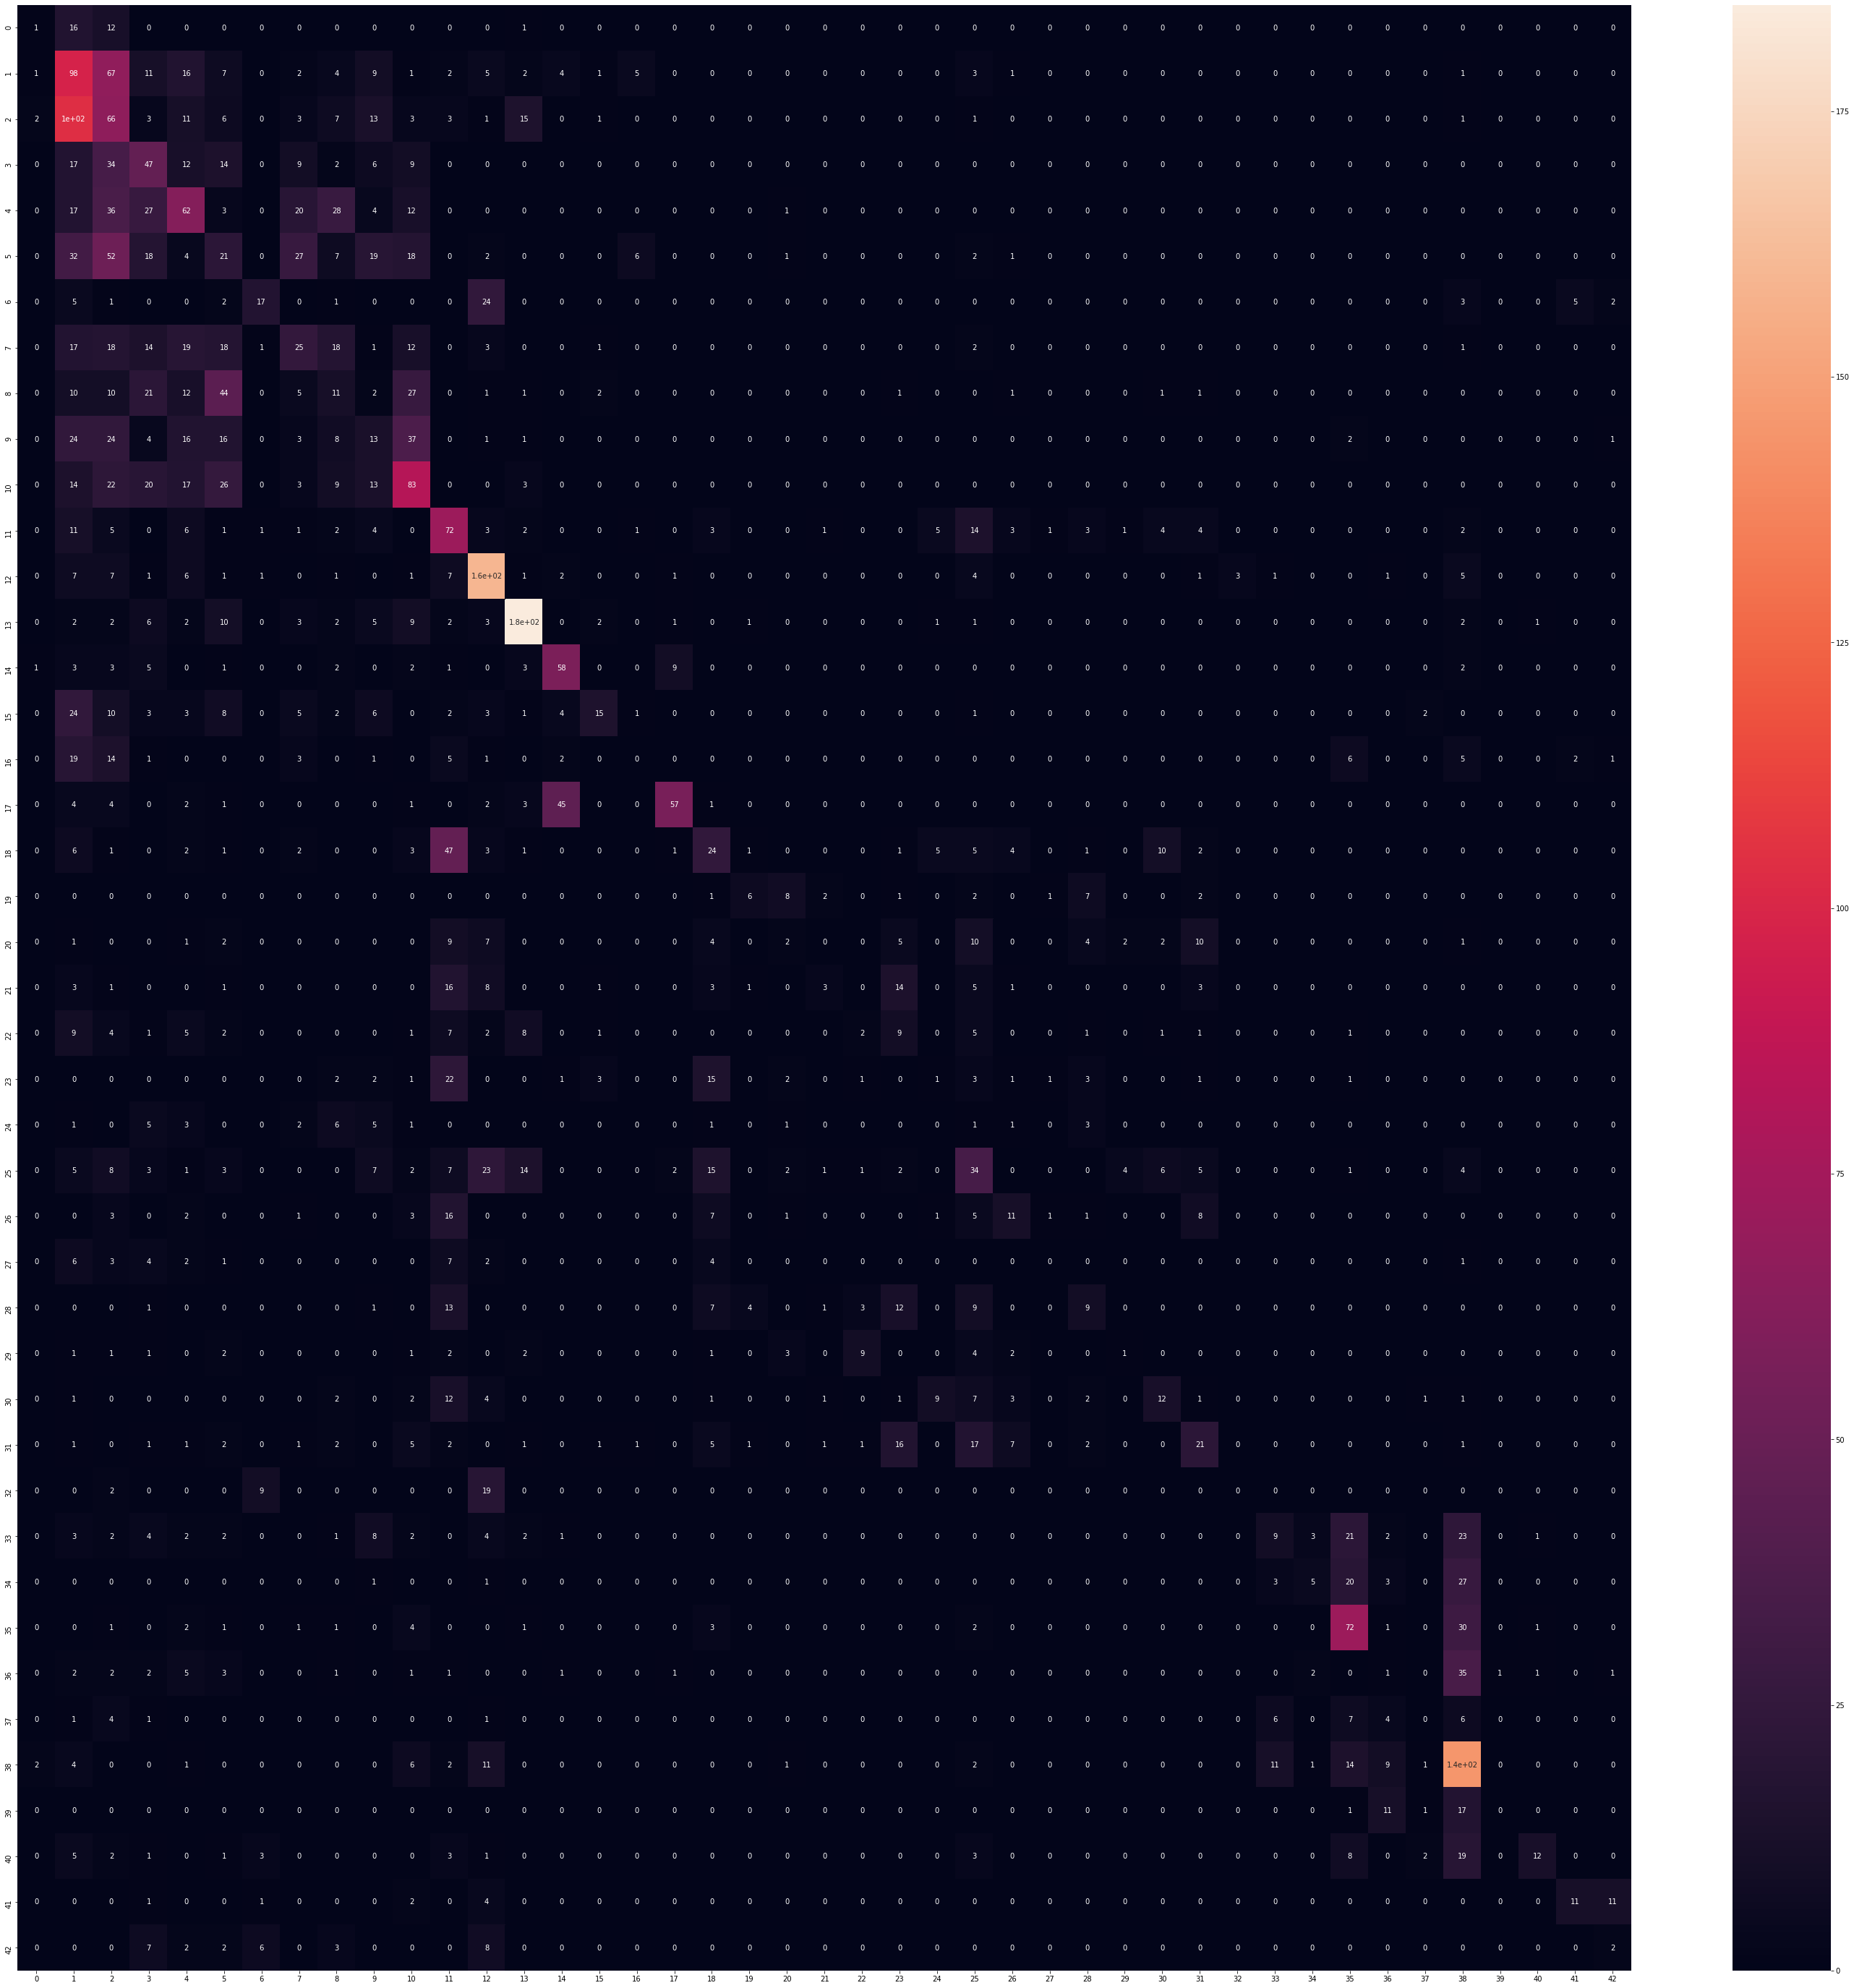

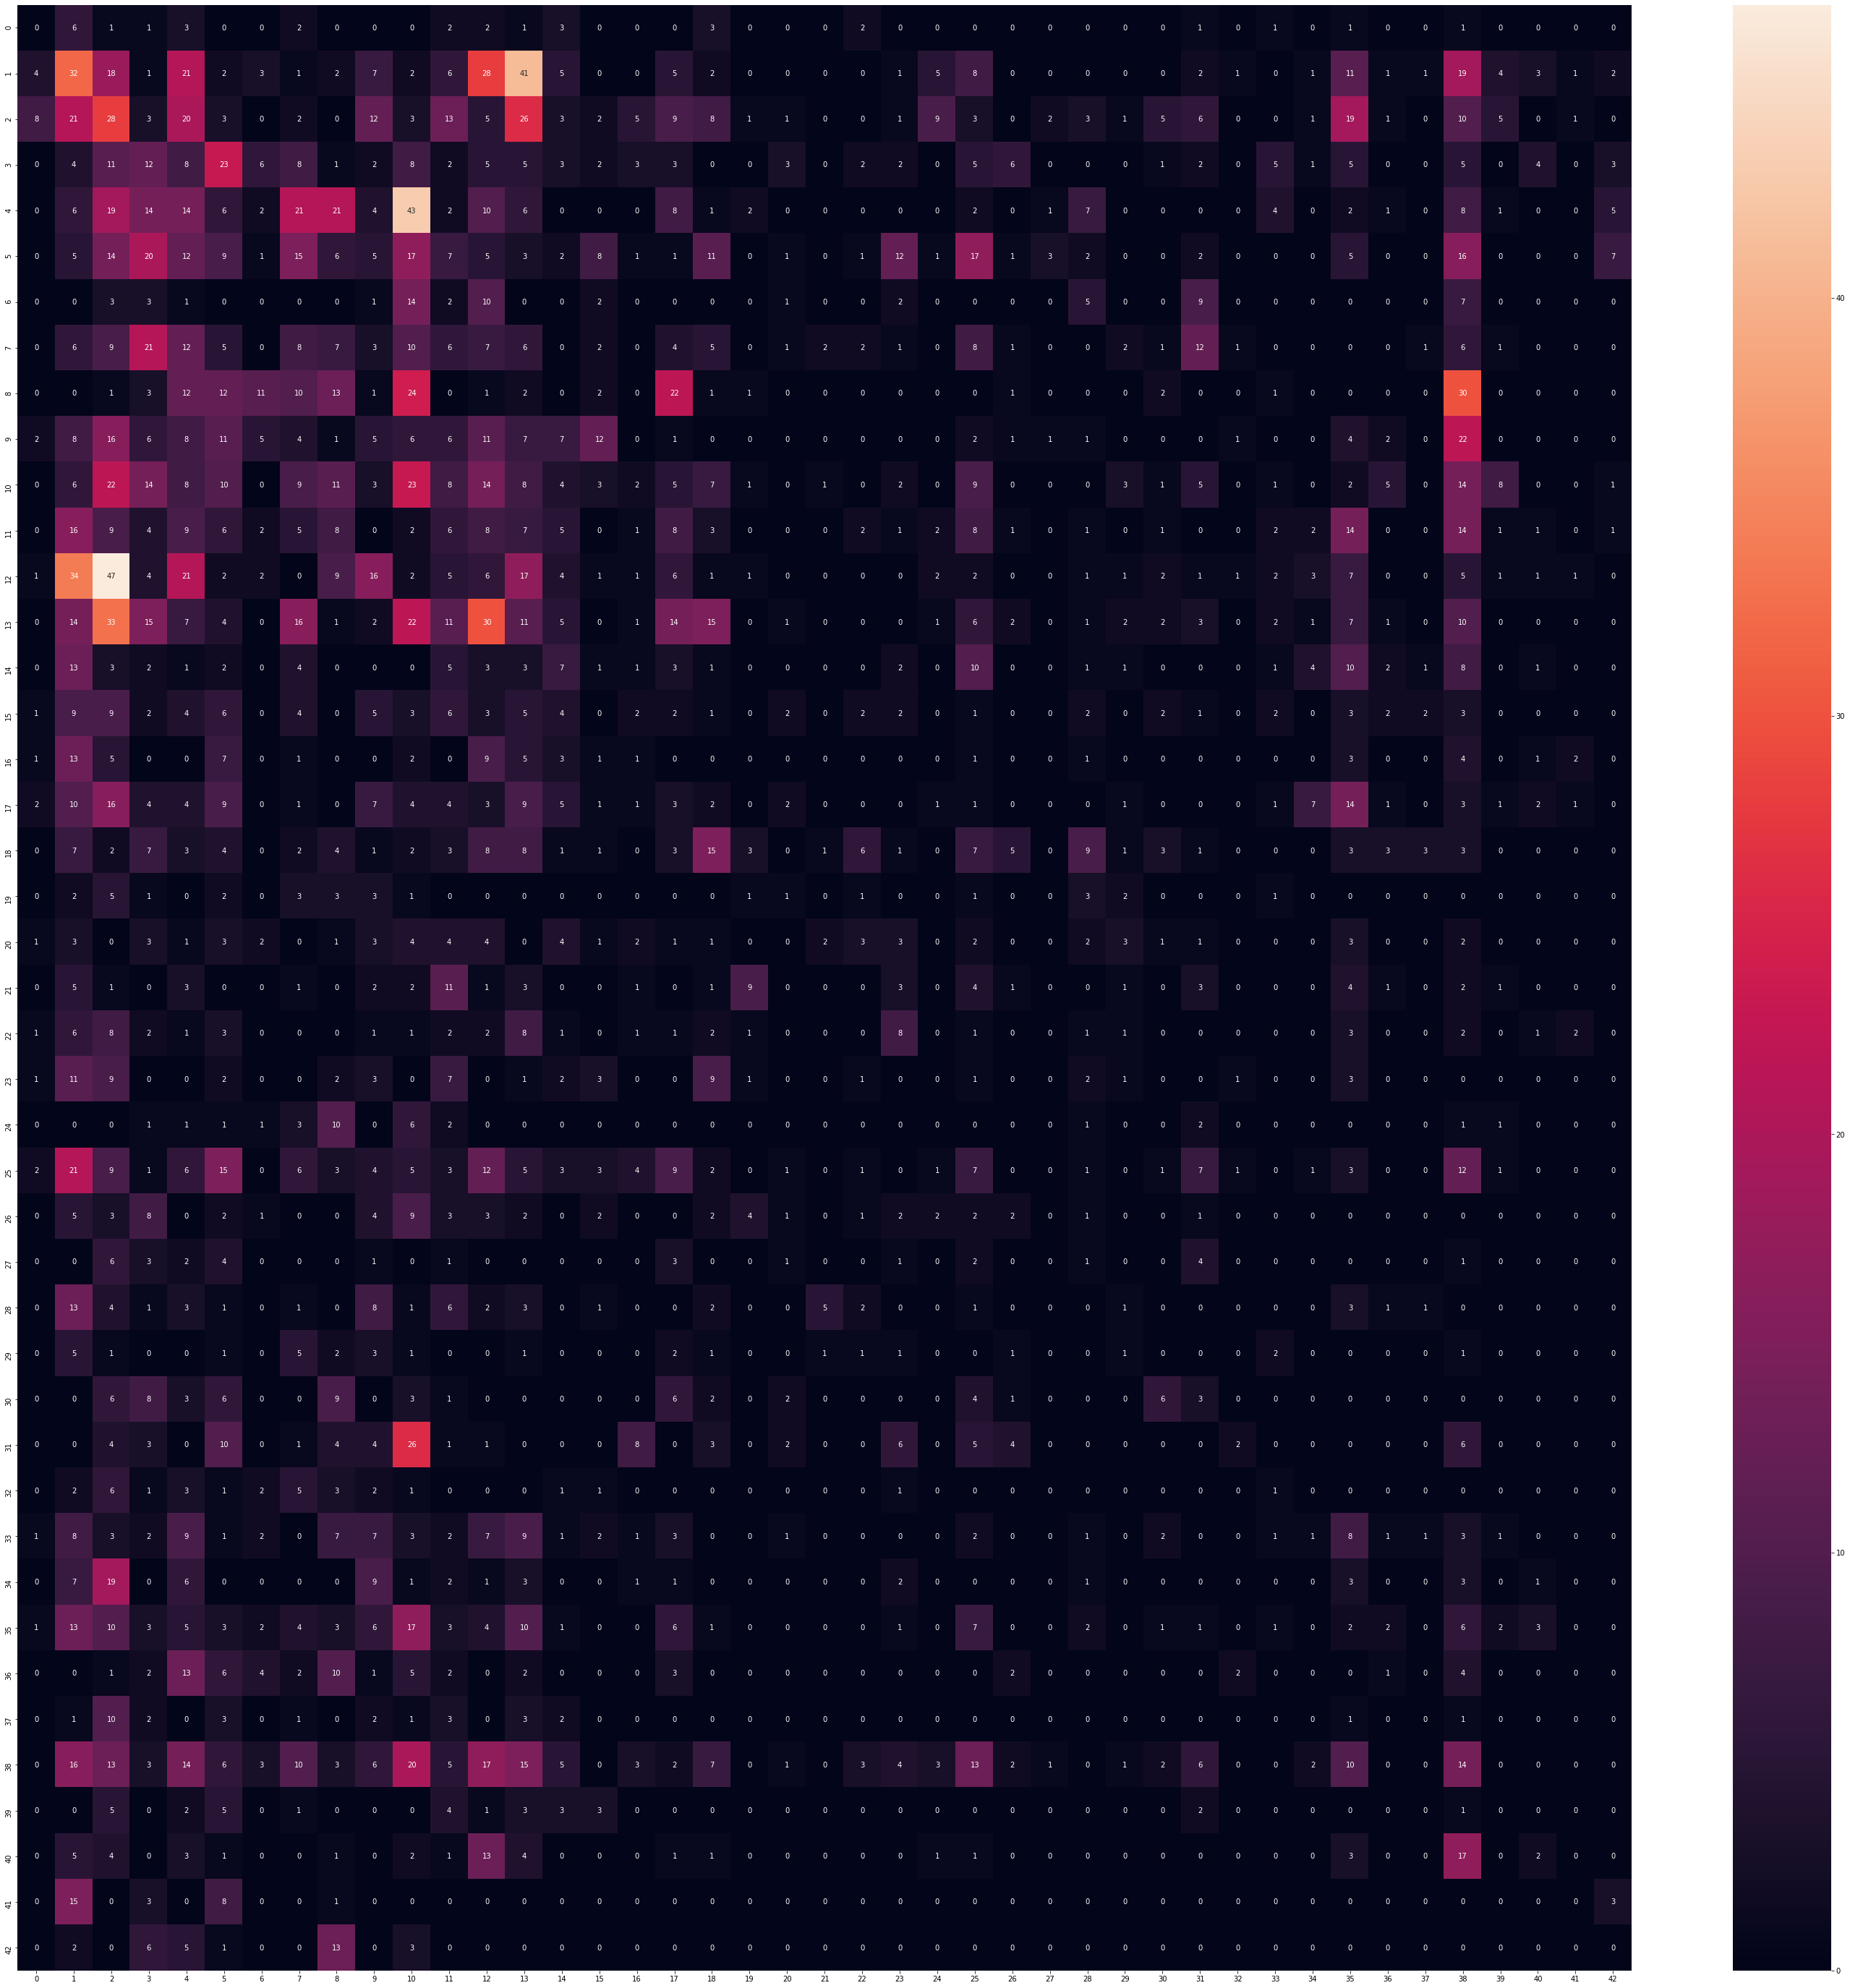

In [ ]:
print('ORIGINAL FEATURE SPACE')
rf_orig = RandomForestClassifier(random_state=42).fit(X_train_1d, y_train)
get_metrics(y_val, rf_orig.predict(X_val_1d)
                         )

print('\n\nPCA FEATURE SPACE')
rf_pca = RandomForestClassifier(random_state=42).fit(X_train_1d_pca, y_train)
X_val_1d_pca = pca.transform(X_val_1d)
get_metrics(y_val,rf_pca.predict(X_val_1d_pca))

print('\n\nKPCA FEATURE SPACE')
X_train_g_1d_kpca = kpca.transform(X_train_g_1d)

rf_kpca = RandomForestClassifier(random_state=42).fit(X_train_g_1d_kpca, y_train)
X_val_1d_kpca = kpca.transform(X_val_g_1d)
get_metrics(y_val, rf_kpca.predict(X_val_1d_kpca))



El accuracy empeoró con las reducciones de dimensionalidad

# 5 Visualización




###5.1 tSNE

Probamos el método de t-SNE para visualización.

In [ ]:
from sklearn.manifold import TSNE
from timeit import default_timer as timer

start = timer()
tsne = TSNE(n_components=3, random_state=0,  perplexity=10)
tsne_features = tsne.fit_transform(X_train_1d)
with open(drive_dir+'tsne','wb') as f:
  pickle.dump(tsne,f)
with open(drive_dir+'tsne_features','wb') as f:
  pickle.dump(tsne_features,f)
  
end = timer()

print("Time taken:", end-start)

Time taken: 7399.03968212


In [ ]:
with open(drive_dir+'tsne_features','rb') as f:
  tsne_features=pickle.load(f)

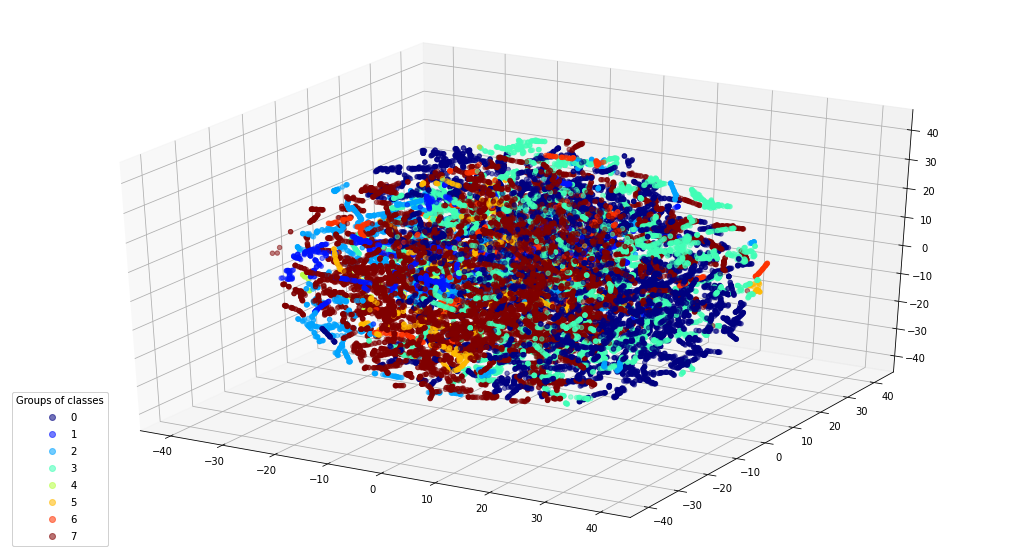

In [ ]:
fig=plt.figure(figsize=(18,10))
cmap_classes = plt.cm.get_cmap('jet', len(group_keywords))

ax = fig.add_subplot(111,projection='3d')

scatter=ax.scatter3D(tsne_features[:,0], tsne_features[:,1], tsne_features[:,2],cmap=cmap_classes, 
                     c=[group_keywords.index(grouped_classes[idx]) for idx in y_train],alpha=0.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Groups of classes")
ax.add_artist(legend1)

###5.2 tSNE con PCA previo

Dado que el método tSNE es susceptible a la maldición de la dimensionalidad, en la bibliografía se sugiere la aplicación de PCA inicialmente como método de reducción de dimensionalidad para obtener menos de 50 nuevos atributos aplicables a tSNE. En este caso tomamos el valor de 30 obtenido en la búsqueda por grilla. Así mismo, probamos la visualización para las clases agrupadas como para todas las clases.


Para las clases agrupadas:

In [ ]:
pca30c = PCA(n_components=30)
pca30c.fit(X_train_1d)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca_30features = pca30c.transform(X_train_1d)

In [ ]:
pca_30features.shape, np.unique(y_train).shape

((34799, 30), (43,))

In [ ]:
start = timer()
tsne = TSNE(n_components=3, random_state=0,  perplexity=10)
pca_tsne_features = tsne.fit_transform(pca_30features)
with open(drive_dir+'pca_tsne','wb') as f:
  pickle.dump(tsne,f)
with open(drive_dir+'pca_tsne_features','wb') as f:
  pickle.dump(pca_tsne_features,f)
  
end = timer()

print("Time taken:", end-start)

In [ ]:
with open(drive_dir+'pca_tsne_features','rb') as f:
  pca_tsne_features=pickle.load(f)

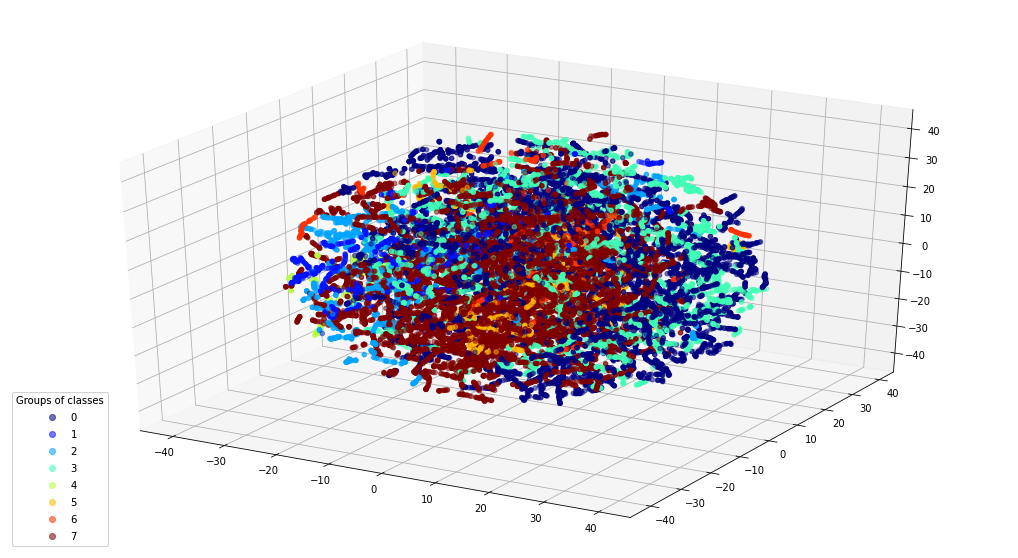

In [ ]:
fig=plt.figure(figsize=(18,10))
cmap_classes = plt.cm.get_cmap('jet', len(group_keywords))

ax = fig.add_subplot(111,projection='3d')

scatter=ax.scatter3D(pca_tsne_features[:,0], pca_tsne_features[:,1], pca_tsne_features[:,2],cmap=cmap_classes, 
                     c=[group_keywords.index(grouped_classes[idx]) for idx in y_train],alpha=0.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Groups of classes")
ax.add_artist(legend1)

Para todas las clases:

In [ ]:
plt.figure(figsize=(16,8))
cmap_classes = plt.cm.get_cmap('jet', len(set(train['labels'])))
plt.scatter(x=pca2c.transform(X_train_1d)[:,0],
            y=pca2c.transform(X_train_1d)[:,1],
            c=y_train,s=35,cmap=cmap_classes,alpha=0.5)
plt.title("PCA de dos dimensiones")
plt.colorbar()
plt.show()

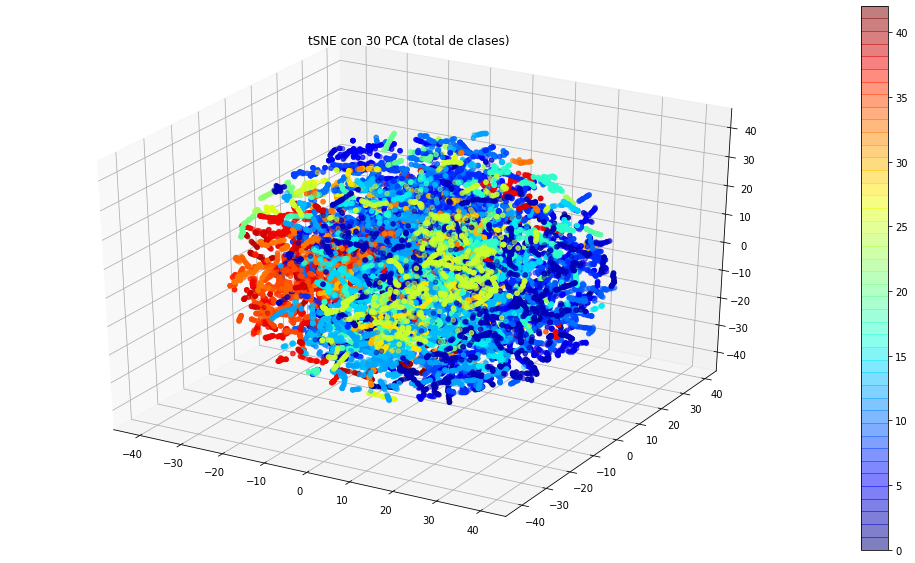

In [ ]:
fig=plt.figure(figsize=(18,10))
cmap_classes = plt.cm.get_cmap('jet', len(set(train['labels'])))

ax = fig.add_subplot(111,projection='3d')

scatter=ax.scatter3D(pca_tsne_features[:,0], pca_tsne_features[:,1], pca_tsne_features[:,2],cmap=cmap_classes, c= y_train,alpha=0.5)
plt.title("tSNE con 30 PCA (total de clases)")
plt.colorbar(scatter)
plt.show()


###5.3 tSNE con PCA previo y diferentes valores de de perplejidad

Además, probamos diferentes valores del hiperparámetro perplejidad, dado que como se establece en el blog TowardsDataScience "es un valor que balancea la atención que el modelo le brinda a aspectos locales y globales de la imagen, lo cual puede tener efectos importantes en la gráfica resultante". Así mismo, la importancia de probar diferentes valores para este hiperparámetro también se resalta en la documentación de sklearn.

Fuente: https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0

perplexity=5 in 1.5e+03 sec


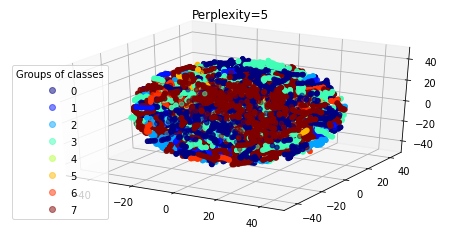

perplexity=10 in 1.5e+03 sec


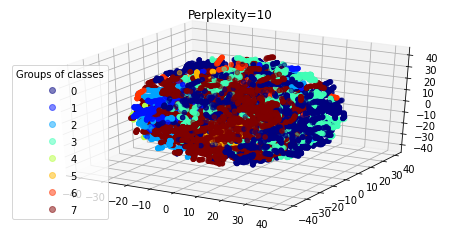

perplexity=30 in 1.5e+03 sec


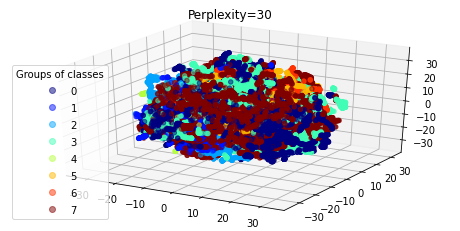

perplexity=50 in 1.6e+03 sec


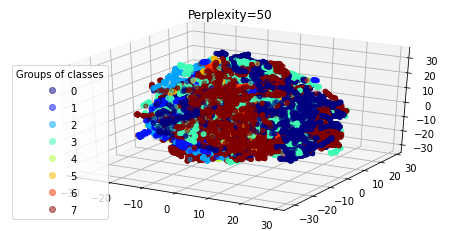

perplexity=100 in 1.8e+03 sec


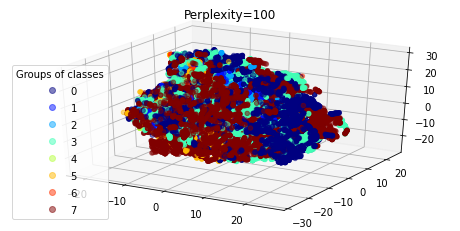

In [ ]:
from matplotlib.ticker import NullFormatter
from time import time

perplexities = [5, 10, 30, 50, 100]

cmap_classes = plt.cm.get_cmap('jet', len(group_keywords))

for i, perplexity in enumerate(perplexities):
    fig = plt.figure(figsize=plt.figaspect(0.5))  
    ax = fig.add_subplot(111, projection='3d')
   
    t0 = time()
    tsne = TSNE(n_components=3, init='random',random_state=0, perplexity=perplexity)
    pca_tsne_features_perp = tsne.fit_transform(pca_30features)
    t1 = time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    scatter = ax.scatter3D(pca_tsne_features_perp[:,0], pca_tsne_features_perp[:,1], pca_tsne_features_perp[:,2],cmap=cmap_classes, c= [group_keywords.index(grouped_classes[idx]) for idx in y_train],alpha=0.5)
    ax.legend(*scatter.legend_elements(),loc="lower left", title="Groups of classes")

    plt.show()


Con ninguno de los experimentos realizados obtuvimos una visualización buena de los datos en la cual se viera tanto el agrupamiento por clase y como la diferenciación con otras categorías. Sin embargo, para ciertos valores de perplejidad, los datos de ciertas clases parecieran agruparse en mayor medida.

# 6 Autoencoders

Utilizamos parte del trabajo realizado para el TP 3

### 6.1 Definir funciones

In [ ]:
#funciones accesorias
def flatten_features(X):
  X_flat = []
  for i in range(len(X)):
    X_flat.append(X[i].flatten())

  return np.array(X_flat)

def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x

    
def loss_function(y_true, y_pred):  ## loss function for using in autoencoder models
    mses = mean_squared_error(y_true, y_pred)
    return K.sum(mses, axis=(1,2))

In [ ]:
#Construcción del Autoencoder
def general_ae(input_size, latent_size):
    input = Input(input_size)
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    
    #Middle
    middle = create_block(x, latent_size)
    
    # Decoder
    up1 = UpSampling2D((2,2))(middle)
    block3 = create_block(up1, 64)
    #up1 = UpSampling2D((2,2))(block3)
    up2 = UpSampling2D((2,2))(block3)
    block4 = create_block(up2, 32)
    #up2 = UpSampling2D((2,2))(block4)
    
    # output
    x = Conv2D(3, 1)(up2)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)


In [ ]:
#Ajuste o entrenamiento del Autoencoder
def adjust_ae(X_train, X_val, input_size, latent_size):
  encoder_ae, model_ae = general_ae(input_size,latent_size)
  model_ae.compile(SGD(1e-3, 0.9), loss=loss_function)
  er = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=0.0001)
  callbacks = [er, lr]
  history = model_ae.fit(X_train, X_train, 
                        batch_size=512,
                        epochs=100,
                        verbose=1,
                        validation_data=(X_val, X_val),
                        shuffle=True, callbacks=callbacks)

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()

  return encoder_ae, model_ae

In [ ]:
#Función para visualizar imágenes originales y reconstruidas mediante el Autoencoder
import random
def plot_reconstructions(original, reconstructed, num=10):  
    n = num
    plt.figure(figsize=(20, 4))
    index = random.sample(np.arange(len(original)).tolist(), 10)

    for i in range(n):
        idx = index[i]
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(original[idx].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(reconstructed[idx].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


### 6.2 Features obtenidas mediante autoencoder (imagen color)
*   Imagen color (3 canales)
*   Todas las observaciones
*   Extracción de features (autoencoders)

Epoch 1/100
68/68 [==============================] - 9s 102ms/step - loss: 39.6787 - val_loss: 33.4135
Epoch 2/100
68/68 [==============================] - 5s 69ms/step - loss: 10.0781 - val_loss: 36.7246
Epoch 3/100
68/68 [==============================] - 5s 69ms/step - loss: 9.0663 - val_loss: 19.9773
Epoch 4/100
68/68 [==============================] - 5s 70ms/step - loss: 8.3562 - val_loss: 19.6685
Epoch 5/100
68/68 [==============================] - 5s 70ms/step - loss: 8.0332 - val_loss: 11.5316
Epoch 6/100
68/68 [==============================] - 5s 70ms/step - loss: 7.4532 - val_loss: 9.8274
Epoch 7/100
68/68 [==============================] - 5s 71ms/step - loss: 7.1039 - val_loss: 8.1533
Epoch 8/100
68/68 [==============================] - 5s 71ms/step - loss: 6.8139 - val_loss: 8.6203
Epoch 9/100
68/68 [==============================] - 5s 71ms/step - loss: 6.6143 - val_loss: 7.1977
Epoch 10/100
68/68 [==============================] - 5s 72ms/step - loss: 6.3721 - val_loss

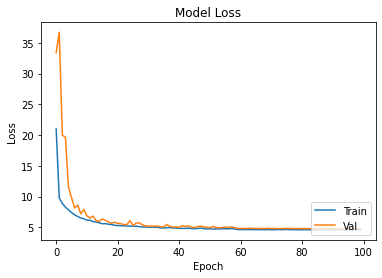

TypeError: ignored

In [ ]:
latent_size = 10
input_size = (32,32,3)

encoder_ae, model_ae = adjust_ae(X_train, X_val, input_size, latent_size)
  

In [ ]:
model_ae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 32)        128 

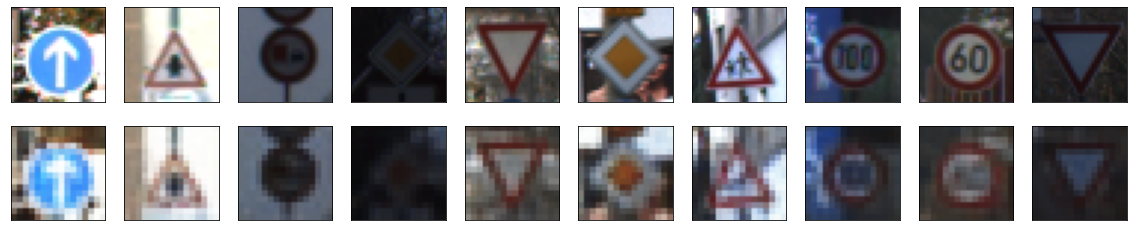

In [ ]:
plot_reconstructions(X_test, model_ae.predict(X_test))

In [ ]:
#Features del espacio latente
Xtr_ae = encoder_ae.predict(X_train)
Xval_ae = encoder_ae.predict(X_val)
Xte_ae = encoder_ae.predict(X_test) 

#Flatten features
Xtr = flatten_features(Xtr_ae)
Xval = flatten_features(Xval_ae)
Xte = flatten_features(Xte_ae)

Xtr.shape, Xval.shape, Xte.shape

((34799, 640), (4410, 640), (12630, 640))

In [ ]:
mlp = MLPClassifier().fit(Xtr, y_train)

Resultados en set de Validación
              precision    recall  f1-score   support

           0       1.00      0.53      0.70        30
           1       0.66      0.88      0.75       240
           2       0.77      0.72      0.74       240
           3       0.82      0.81      0.82       150
           4       0.76      0.93      0.83       210
           5       0.75      0.62      0.68       210
           6       0.63      0.98      0.77        60
           7       0.60      0.85      0.71       150
           8       0.71      0.34      0.46       150
           9       0.81      0.82      0.82       150
          10       0.89      0.97      0.92       210
          11       0.85      0.86      0.86       150
          12       0.97      1.00      0.98       210
          13       0.95      0.96      0.95       240
          14       1.00      0.98      0.99        90
          15       0.93      0.89      0.91        90
          16       1.00      0.63      0.78      

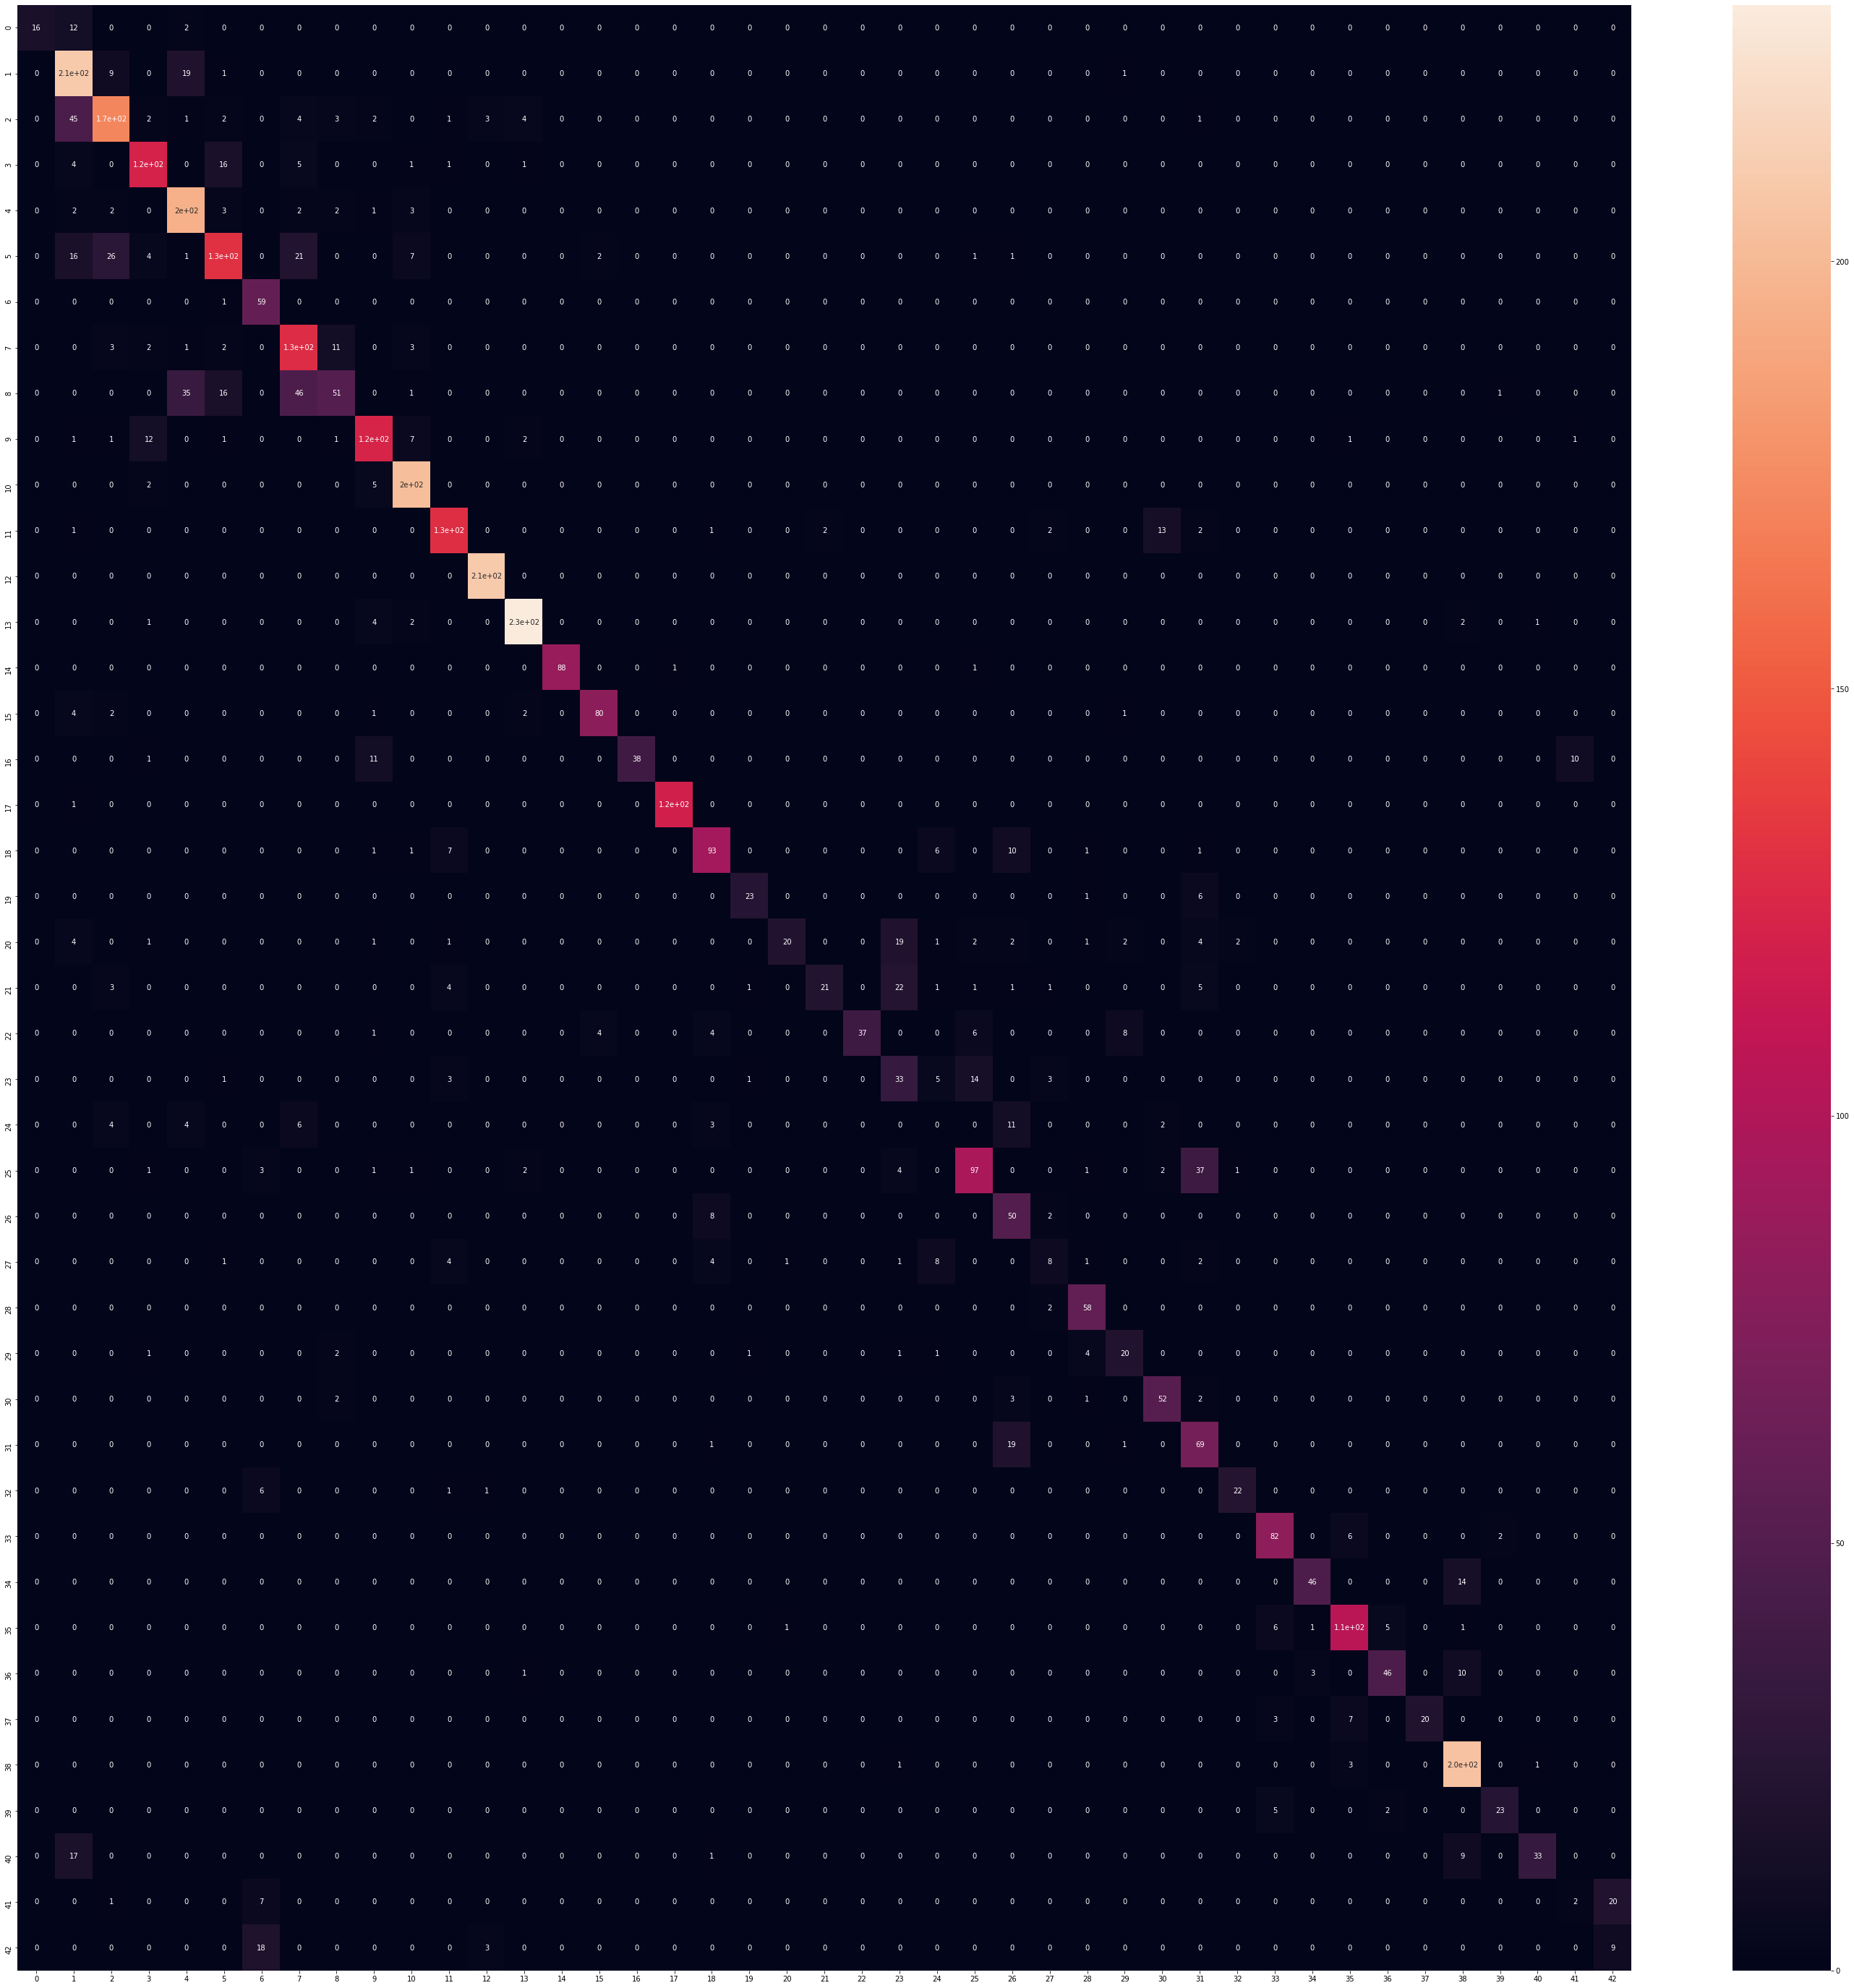

In [ ]:
print('Resultados en set de Validación')
ypred = mlp.predict(Xval)
get_metrics(y_val, ypred)

*Entrenamos un autoencoder para reconstruir las imágenes originales, con el propósito luego de obtener las características generadas por el bloque codificador y de esta manera reducir la cantidad de atributos a la entrada del clasificador. Si bien la performance en entrenamiento es acpetable y todas las clases son detectadas en mayor o menor medida, hay dos clases que se pierden en el set de validación.*

### 6.2 GridSearch con features obtenidas mediante autoencoder (imagen color)
*   Imagen color (3 canales)
*   Todas las observaciones
*   Extracción de features (autoencoders)

In [ ]:
#Features del espacio latente
Xtr_ae = encoder_ae.predict(X_train)
Xval_ae = encoder_ae.predict(X_val)
Xte_ae = encoder_ae.predict(X_test) 

#Flatten features
Xtr = flatten_features(Xtr_ae)
Xval = flatten_features(Xval_ae)
Xte = flatten_features(Xte_ae)

Xtr.shape, Xval.shape, Xte.shape

((34799, 640), (4410, 640), (12630, 640))

In [ ]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(Xtr, y_train) 

with open(drive_dir+'autoencoderGS','wb') as f:
  pickle.dump(clf,f)


In [ ]:
mlp = clf.best_estimator_

Resultados en set de Validación
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        30
           1       0.71      0.84      0.77       240
           2       0.76      0.69      0.72       240
           3       0.56      0.91      0.70       150
           4       0.75      0.82      0.78       210
           5       0.89      0.76      0.82       210
           6       0.63      1.00      0.77        60
           7       0.67      0.77      0.71       150
           8       0.73      0.52      0.61       150
           9       0.90      0.83      0.87       150
          10       0.93      0.99      0.96       210
          11       0.87      0.92      0.89       150
          12       0.99      0.99      0.99       210
          13       0.98      0.95      0.97       240
          14       0.97      0.92      0.94        90
          15       0.92      0.88      0.90        90
          16       1.00      0.48      0.65      

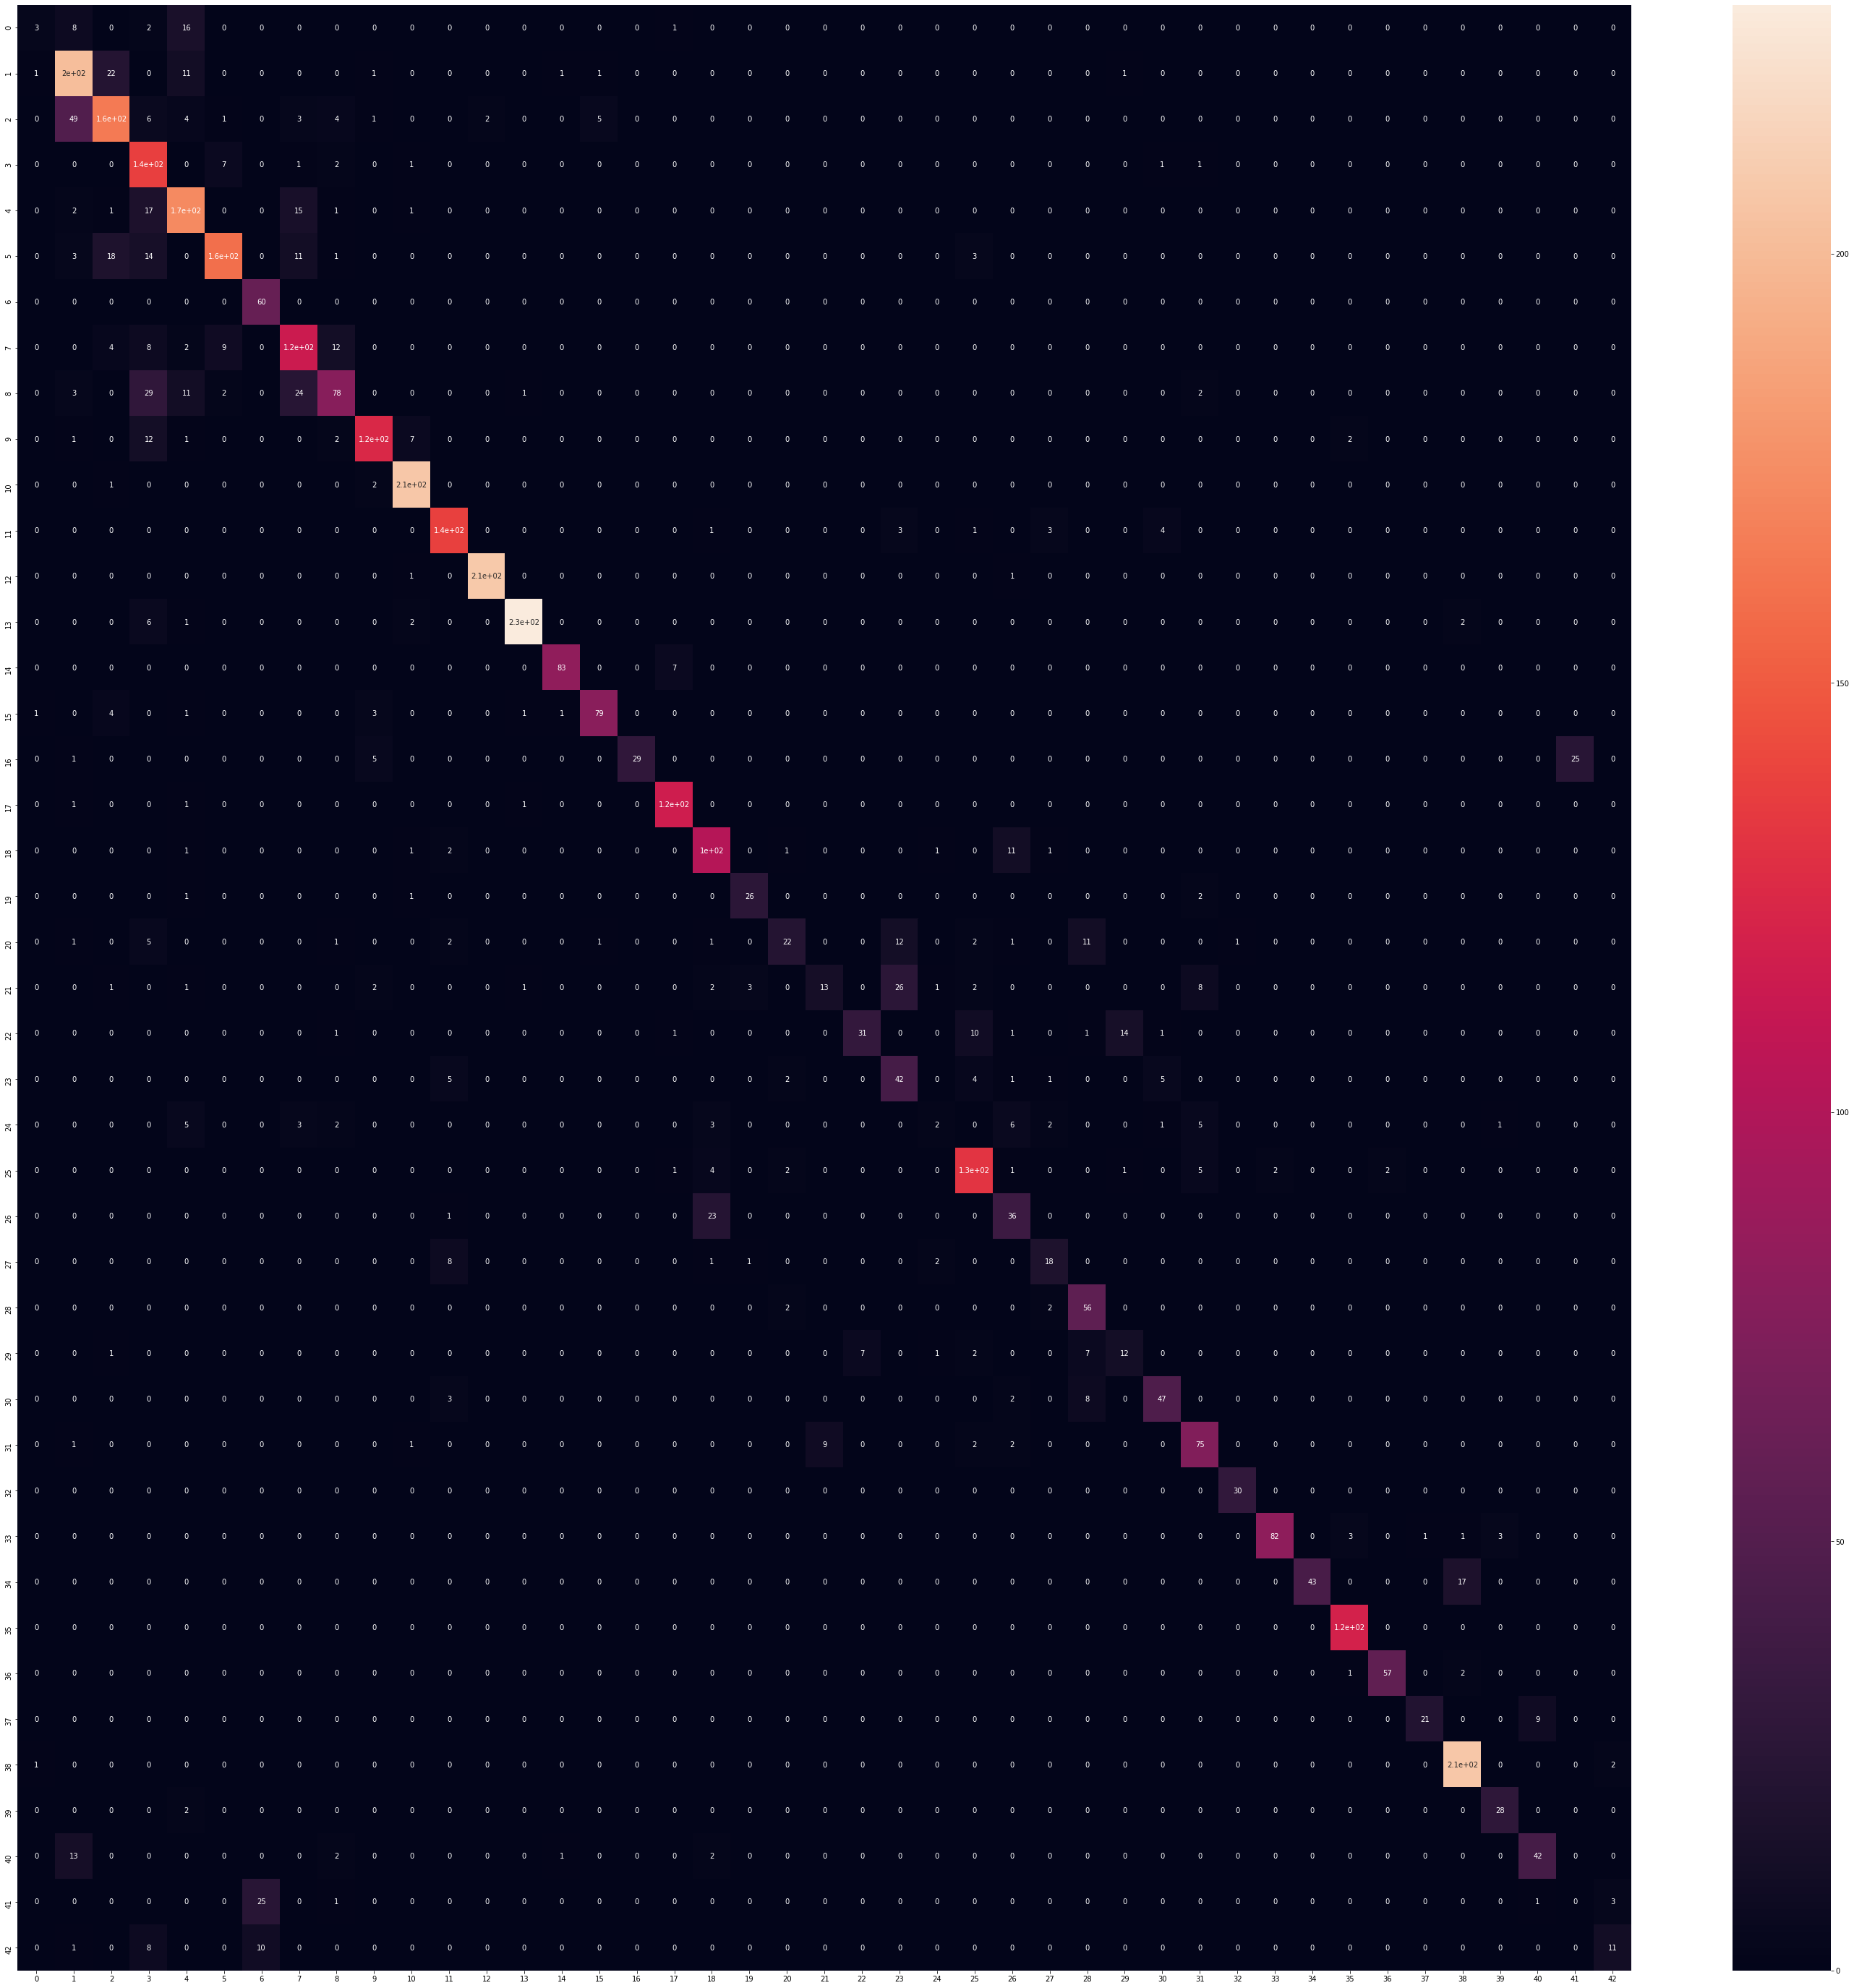

In [ ]:
print('Resultados en set de Validación')
ypred = mlp.predict(Xval)
get_metrics(y_val, ypred)

Observamos que al usar el autoencoder como reductor de dimensionalidad, el accuracy obtenido con un MLP es bueno (0.81 promedio) pero en realidad empeora con respecto a usar directamente el MLP (que obtuvo 0.86). Incluso optimizando con búsqueda por grilla 
los parámetros del clasificador MLP, el accuracy obtenido usando las features del autoencoder no supera al de las features originales.


# Conclusion

Consideramos que la reducción de dimensionalidad no fue útil en este problema, o no conseguimos aplicarla correctamente. Posiblemente se pierda demasiada información de localización al trabajar las imágenes en una dimensión. Métodos de mayor complejidad como el perceptrón multicapa consiguen obtener una representación de 100 features que resultó la mejor para resolver el problema de clasificación. Los métodos de frontera lineal, ya sea PCA o Kernel PCA que define la frontera en otro espacio, fallan en un problema de tantas clases (k=43) como este. Además, notamos también que el dataset fue armado probablemente con métodos artificiales, ya que las imágenes de cada clase son muy similares entre sí. Una dificultad importante en el trabajo fue el nivel de procesamiento computacional requerido para trabajar el dataset. Cada método costó muchas horas de ajustes y no conseguimos una metodología satisfactoria con Colab, ya que muchos intentos se cortaban con la sesión o explotaban la memoria RAM. 